In [1]:
# ----------------------------------------
# 📦 1. IMPORTS & SETUP (PyTorch only)
# ----------------------------------------
import os
import glob
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler
from torch.optim.swa_utils import AveragedModel, SWALR

import albumentations as A
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import jaccard_score
from tqdm import tqdm
from skimage.transform import resize
import torchvision.transforms as T
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90, Compose
from albumentations.pytorch import ToTensorV2
from matplotlib.colors import ListedColormap, BoundaryNorm
import gc # For garbage collection

In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")


CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA RTX A6000


In [3]:
import shutil

# WARNING: This will delete all previous model checkpoints
shutil.rmtree("/home/my22/vienna/SPARK_TRAINING/brats_kfold_runs", ignore_errors=True)
print("✅ Old checkpoints deleted.")


✅ Old checkpoints deleted.


In [4]:
# ----------------------------------------
# 🔧 1. Torch Setup
# ----------------------------------------
torch.manual_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ----------------------------------------
# ⚙️ 2. CONFIGURATIONS
# ----------------------------------------
NUM_CLASSES = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256
NUM_EPOCHS = 50
BATCH_SIZE = 8
NUM_FOLDS = 5
LEARNING_RATE = 1e-4
IMG_CHANNELS = 4 # Input channels for MRI data (e.g., T1, T1ce, T2, FLAIR)
OUTPUT_CHANNELS = NUM_CLASSES # Model's output channels must match NUM_CLASSES
USE_CE = True # Flag for using CrossEntropyLoss component in full_loss 
WEIGHT_DECAY = 1e-5 # L2 regularization strength
DROPOUT_RATE = 0.2 # Dropout rate for AttentionUNet

# ✅ DATA PATHS
INPUT_DIR = '/home/my22/vienna/SPARK_TRAINING/Savanah_AI_Mega_Training/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2'
VALIDATION_DATA_DIR = '/home/my22/vienna/SPARK_TRAINING/Savanah_AI_Mega_Training/BraTS2024-SSA-Challenge-ValidationData'
# DATA_DIR seems redundant if TRAINING_DATA_DIR is derived from INPUT_DIR
# DATA_DIR = '/kaggle/input/miccai/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2'
SAVE_DIR = 'kfold_checkpoints' # Directory to save model checkpoints
LOG_DIR = 'runs' # For TensorBoard logs

# ✅ Ensure proper path to training subjects (as per provided logic)
if len(os.listdir(INPUT_DIR)) == 1 and os.path.isdir(os.path.join(INPUT_DIR, os.listdir(INPUT_DIR)[0])):
    subfolder = os.listdir(INPUT_DIR)[0]
    TRAINING_DATA_DIR = os.path.join(INPUT_DIR, subfolder)
else:
    TRAINING_DATA_DIR = INPUT_DIR

# ✅ Output directory (create it after defining it)
OUTPUT_DIR = '/home/my22/vienna/SPARK_TRAINING/Savanah_AI_Mega_Training/preprocessed'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Global configurations and device setup complete.")

# ----------------------------------------
# 🧠 3. Dataset Path Validation Helper
# ----------------------------------------
def print_dataset_usage(name, data_dir):
    print(f"\n📁 Dataset: {name}")
    if not os.path.exists(data_dir):
        print(f"❌ Error: Path not found → {data_dir}")
        return
    subjects = sorted(glob.glob(os.path.join(data_dir, '*')))
    print(f"✅ Found {len(subjects)} subject folders")
    if len(subjects) > 0:
        example = subjects[0]
        print(f"\n🔍 Example subject: {os.path.basename(example)}")
        for f in glob.glob(os.path.join(example, '*')):
            print("    -", os.path.basename(f))

print_dataset_usage("BraTS 2025 Training Data", TRAINING_DATA_DIR)
print_dataset_usage("BraTS 2025 Validation Data", VALIDATION_DATA_DIR)

Using device: cuda
Global configurations and device setup complete.

📁 Dataset: BraTS 2025 Training Data
✅ Found 61 subject folders

🔍 Example subject: BraTS-SSA-00002-000
    - BraTS-SSA-00002-000-t1n.nii.gz
    - BraTS-SSA-00002-000-seg.nii.gz
    - BraTS-SSA-00002-000-t1c.nii.gz
    - BraTS-SSA-00002-000-t2f.nii.gz
    - BraTS-SSA-00002-000-t2w.nii.gz

📁 Dataset: BraTS 2025 Validation Data
✅ Found 35 subject folders

🔍 Example subject: BraTS-SSA-00125-000
    - BraTS-SSA-00125-000-t1c.nii.gz
    - BraTS-SSA-00125-000-t1n.nii.gz
    - BraTS-SSA-00125-000-t2f.nii.gz
    - BraTS-SSA-00125-000-t2w.nii.gz


In [5]:
# ----------------------------------------
# 💾 4. NIfTI Save Functions
# ----------------------------------------
def save_prediction_as_nifti(pred_volume, affine, header, filename="prediction.nii.gz"):
    """
    Save predicted label map (3D volume) to NIfTI format.
    pred_volume: 3D numpy array (H, W, D)
    affine, header: from a reference NIfTI file
    """
    out_path = os.path.join(OUTPUT_DIR, filename)
    pred_nifti = nib.Nifti1Image(pred_volume.astype(np.uint8), affine=affine, header=header)
    nib.save(pred_nifti, out_path)
    print(f"✅ Saved 3D prediction as NIfTI → {out_path}")

def save_prediction_slice_nii(pred_mask_2d, save_path, affine=np.eye(4)):
    """
    Save a 2D predicted mask slice to NIfTI format.
    pred_mask_2d: 2D numpy array (H, W)
    save_path: Full path to save the NIfTI file
    affine: 4x4 affine matrix. For 2D slices without original 3D context, np.eye(4) is a placeholder.
    """
    # NIfTI expects 3D data, so add a dummy dimension for 2D slice
    pred_volume_3d = pred_mask_2d[np.newaxis, :, :] # (1, H, W) or (H, W, 1) depending on convention
    # Let's make it (H, W, 1) to match common NIfTI expectations for single slice
    pred_volume_3d = pred_mask_2d[:, :, np.newaxis]

    pred_nii = nib.Nifti1Image(pred_volume_3d.astype(np.uint8), affine)
    nib.save(pred_nii, save_path)
    # print(f"Saved 2D slice prediction to {save_path}") # Uncomment for verbose output

print("NIfTI save functions loaded.")

NIfTI save functions loaded.



--- Performing single slice prediction for subject: BraTS-SSA-00097-000 ---
Selected slice with tumor: 66
Model not found. Please ensure 'model_eval' is trained and loaded before attempting prediction.


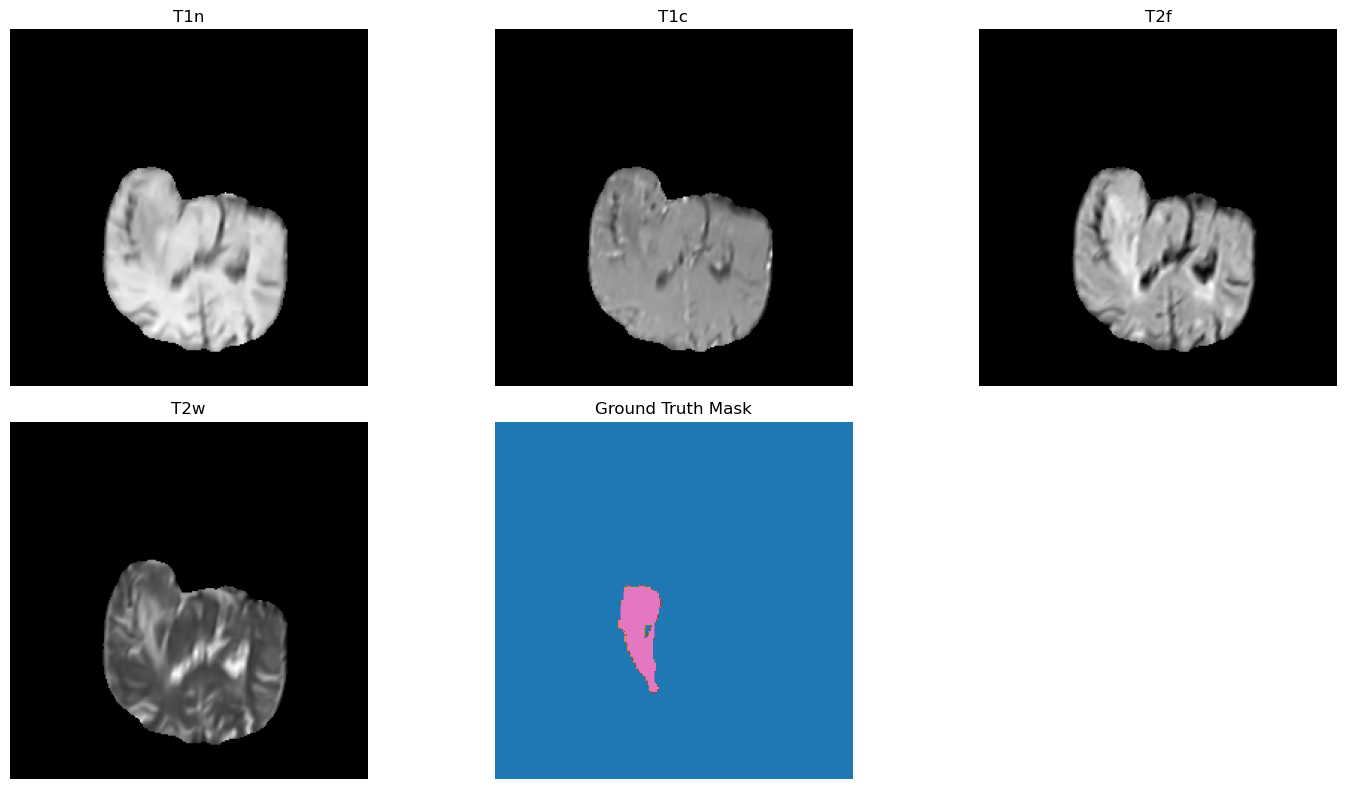

/tmp/ipykernel_2627158/1649010795.py:178: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', NUM_CLASSES) # Get tab10 colormap, specify NUM_CLASSES discrete colors


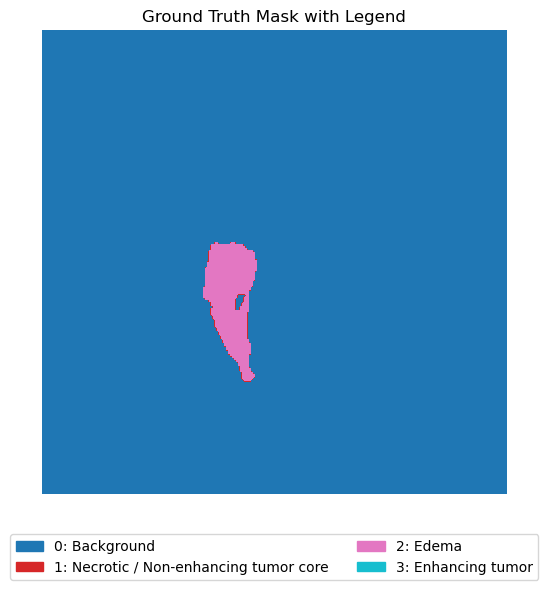

In [6]:
# ----------------------------------------
# ⚙️ CONFIGURATIONS (Re-define if needed, ensuring consistency with global scope)
# ----------------------------------------
# Ensure these are consistent with the global CONFIGURATIONS section
# DEVICE = torch.device("cuda" if torch.cuda.cuda.is_available() else "cpu")
# TRAINING_DATA_DIR is already defined globally based on your initial config logic
# SAVE_DIR is already defined globally for checkpoints
# OUTPUT_DIR is already defined globally for NIfTI outputs

# 📁 Set subject path - Using the TRAINING_DATA_DIR determined earlier
all_subject_paths = sorted(glob.glob(os.path.join(TRAINING_DATA_DIR, '*')))
if not all_subject_paths:
    print(f"Error: No subjects found in {TRAINING_DATA_DIR}. Cannot perform single slice prediction.")
    # might want to exit or raise an error here if no data.
else:
    # Use a specific subject or pick a random one
    # subject_path = os.path.join(TRAINING_DATA_DIR, "BraTS-SSA-00002-000") # specific subject
    subject_path = random.choice(all_subject_paths) # Randomly pick a subject for demonstration

    print(f"\n--- Performing single slice prediction for subject: {os.path.basename(subject_path)} ---")

    # ✅ Load modalities and ground truth mask
    # Note: Using try-except for robustness in case a file is missing
    try:
        image_t1n_nii = nib.load(os.path.join(subject_path, [f for f in os.listdir(subject_path) if "t1n" in f][0]))
        image_t1c_nii = nib.load(os.path.join(subject_path, [f for f in os.listdir(subject_path) if "t1c" in f][0]))
        image_t2f_nii = nib.load(os.path.join(subject_path, [f for f in os.listdir(subject_path) if "t2f" in f][0]))
        image_t2w_nii = nib.load(os.path.join(subject_path, [f for f in os.listdir(subject_path) if "t2w" in f][0]))
        mask_nii = nib.load(os.path.join(subject_path, [f for f in os.listdir(subject_path) if "seg" in f][0]))

        image_t1n = image_t1n_nii.get_fdata().astype(np.float32)
        image_t1c = image_t1c_nii.get_fdata().astype(np.float32)
        image_t2f = image_t2f_nii.get_fdata().astype(np.float32)
        image_t2w = image_t2w_nii.get_fdata().astype(np.float32)
        mask = mask_nii.get_fdata().astype(np.uint8)

        # Normalize individual modalities before stacking
        image_t1n = (image_t1n - np.min(image_t1n)) / (np.max(image_t1n) - np.min(image_t1n) + 1e-8)
        image_t1c = (image_t1c - np.min(image_t1c)) / (np.max(image_t1c) - np.min(image_t1c) + 1e-8)
        image_t2f = (image_t2f - np.min(image_t2f)) / (np.max(image_t2f) - np.min(image_t2f) + 1e-8)
        image_t2w = (image_t2w - np.min(image_t2w)) / (np.max(image_t2w) - np.min(image_t2w) + 1e-8)

        # 🎲 Random slice (ensure it has some tumor, or pick randomly if no tumor check is needed)
        # Find slices with tumor (mask value > 0)
        valid_slices = np.where(np.any(mask > 0, axis=(0, 1)))[0]
        if len(valid_slices) > 0:
            n_slice = random.choice(valid_slices)
            print(f"Selected slice with tumor: {n_slice}")
        else:
            n_slice = random.randint(0, mask.shape[2] - 1)
            print(f"No tumor found in any slice, selecting random slice: {n_slice}")


        # ---------------------------------------------------
        # 📌 Predict model output for this slice
        # ---------------------------------------------------
        def predict_slice(model, slice_index, image_t1n_vol, image_t1c_vol, image_t2f_vol, image_t2w_vol, img_height, img_width):
            model.eval()
            
            # Extract 2D slices
            slice_t1n = image_t1n_vol[:, :, slice_index]
            slice_t1c = image_t1c_vol[:, :, slice_index]
            slice_t2f = image_t2f_vol[:, :, slice_index]
            slice_t2w = image_t2w_vol[:, :, slice_index]

            # Stack for input to model (C, H, W)
            image_stack = np.stack([slice_t1n, slice_t1c, slice_t2f, slice_t2w], axis=0)
            
            # Apply normalization consistent with the training (0-1 normalization for the entire slice stack)
            # Or if the training normalized per channel, do that here
            # Assuming 0-1 was done globally on the whole volume during dataset loading, this is consistent.
            # If want to use the mean/std normalization, uncomment/modify the next line:
            # image_stack = (image_stack - image_stack.mean(axis=(1, 2), keepdims=True)) / (image_stack.std(axis=(1, 2), keepdims=True) + 1e-8)
            
            # Convert to PyTorch tensor and resize
            tensor = torch.from_numpy(image_stack).float().unsqueeze(0).to(DEVICE) # Add batch dimension

            # Apply resizing directly on the tensor
            tensor = F.interpolate(tensor, size=(img_height, img_width), mode='bilinear', align_corners=False)

            with torch.no_grad():
                logits = model(tensor)  # [1, 4, H, W]
                pred = torch.argmax(F.softmax(logits, dim=1), dim=1)  # [1, H, W]
                return pred.squeeze(0).cpu().numpy()

        # ---------------------------------------------------
        # 🖼️ Plot inputs, ground truth, and prediction
        # ---------------------------------------------------
        plt.figure(figsize=(15, 8))

        # Using np.rot90 for consistent orientation with original images
        plt.subplot(2, 3, 1)
        plt.imshow(np.rot90(image_t1n[:, :, n_slice]), cmap='gray')
        plt.title('T1n')
        plt.axis('off')

        plt.subplot(2, 3, 2)
        plt.imshow(np.rot90(image_t1c[:, :, n_slice]), cmap='gray')
        plt.title('T1c')
        plt.axis('off')

        plt.subplot(2, 3, 3)
        plt.imshow(np.rot90(image_t2f[:, :, n_slice]), cmap='gray')
        plt.title('T2f')
        plt.axis('off')

        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(image_t2w[:, :, n_slice]), cmap='gray')
        plt.title('T2w')
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(mask[:, :, n_slice]), cmap='tab10', vmin=0, vmax=NUM_CLASSES - 1)
        plt.title('Ground Truth Mask')
        plt.axis('off')
        # plt.colorbar() # Colorbar for categorical data is often better as a separate legend

        # ✅ Predict and save if model is defined
        if 'model_eval' in globals() and model_eval is not None: # Use model_eval from the evaluation section
            # Pass full 3D volumes to predict_slice
            pred_mask = predict_slice(model_eval, n_slice, image_t1n, image_t1c, image_t2f, image_t2w, IMG_HEIGHT, IMG_WIDTH)

            plt.subplot(2, 3, 6)
            plt.imshow(np.rot90(pred_mask), cmap='tab10', vmin=0, vmax=NUM_CLASSES - 1)
            plt.title('Model Prediction')
            plt.axis('off')
            # plt.colorbar()

            # ✅ Save prediction as .nii.gz
            nii_save_dir = "./nii_predictions" # Use a new variable to avoid confusion with OUTPUT_DIR
            os.makedirs(nii_save_dir, exist_ok=True)

            subject_id = os.path.basename(subject_path)
            filename = f"{subject_id}_slice{n_slice:03d}_pred.nii.gz"
            save_path = os.path.join(nii_save_dir, filename)

            # Make empty 3D volume for the slice and insert prediction
            # Ensure pred_mask is resized to original NIfTI slice dimensions if necessary
            # For simplicity here, assuming pred_mask is already the target size (IMG_HEIGHT, IMG_WIDTH)
            # If original size differs, we need to resize pred_mask back to original (e.g., mask.shape[0], mask.shape[1])
            
            # This reconstruction assumes the prediction should fill a slice within the original mask dimensions.
            # If pred_mask is 256x256 and original mask is different, we do need to resize pred_mask.
            # Here, we assume the original mask.shape[0:2] is similar to IMG_HEIGHT, IMG_WIDTH after loading and transform
            # For robust saving, ensure pred_mask is resized back to mask.shape[0:2] before inserting.
            
            # Let's add a resize step here to ensure the saved NIfTI matches original dimensions
            if pred_mask.shape[0] != mask.shape[0] or pred_mask.shape[1] != mask.shape[1]:
                # Using nearest-neighbor for mask resizing to preserve integer labels
                pred_mask_resized = transforms.ToPILImage()(torch.from_numpy(pred_mask).unsqueeze(0).float())
                pred_mask_resized = transforms.Resize((mask.shape[0], mask.shape[1]), interpolation=transforms.InterpolationMode.NEAREST)(pred_mask_resized)
                pred_mask_resized = transforms.ToTensor()(pred_mask_resized).squeeze(0).numpy().astype(np.uint8)
            else:
                pred_mask_resized = pred_mask

            pred_volume = np.zeros_like(mask, dtype=np.uint8)
            pred_volume[:, :, n_slice] = pred_mask_resized

            # Save using original mask affine and header
            save_prediction_as_nifti(pred_volume, affine=mask_nii.affine, header=mask_nii.header, filename=filename)

        else:
            print("Model not found. Please ensure 'model_eval' is trained and loaded before attempting prediction.")

        plt.tight_layout()
        plt.show()

        import matplotlib.patches as mpatches

        # Define class labels and colors (as per your snippet)
        class_labels = {
            0: 'Background',
            1: 'Necrotic / Non-enhancing tumor core',
            2: 'Edema',
            3: 'Enhancing tumor'
        }

        cmap = plt.cm.get_cmap('tab10', NUM_CLASSES) # Get tab10 colormap, specify NUM_CLASSES discrete colors
        legend_handles = [
            mpatches.Patch(color=cmap(label), label=f"{label}: {class_labels[label]}") # Pass integer label directly to cmap
            for label in sorted(class_labels.keys())
        ]

        # Plot the ground truth mask again with legend (use rot90 mask slice)
        plt.figure(figsize=(6, 6))
        plt.imshow(np.rot90(mask[:, :, n_slice]), cmap=cmap, vmin=0, vmax=NUM_CLASSES - 1)
        plt.title("Ground Truth Mask with Legend")
        plt.axis("off")
        plt.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred during single slice prediction/visualization: {e}")

In [7]:
print(type(TRAINING_DATA_DIR))


<class 'str'>


In [8]:
import os, glob

print("Using training data from:", TRAINING_DATA_DIR)
print("Subdirectories found:", os.listdir(TRAINING_DATA_DIR))

# Inspect one sample directory (manually or by code)
example_dir = os.path.join(TRAINING_DATA_DIR, os.listdir(TRAINING_DATA_DIR)[0])
print("Files in example subject folder:", os.listdir(example_dir))


Using training data from: /home/my22/vienna/SPARK_TRAINING/Savanah_AI_Mega_Training/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2
Subdirectories found: ['BraTS-SSA-00002-000', 'BraTS-SSA-00007-000', 'BraTS-SSA-00008-000', 'BraTS-SSA-00011-000', 'BraTS-SSA-00010-000', 'BraTS-SSA-00012-000', 'BraTS-SSA-00014-000', 'BraTS-SSA-00015-000', 'BraTS-SSA-00025-000', 'BraTS-SSA-00026-000', 'BraTS-SSA-00037-000', 'BraTS-SSA-00028-000', 'BraTS-SSA-00041-000', 'BraTS-SSA-00044-000', 'BraTS-SSA-00046-000', 'BraTS-SSA-00049-000', 'BraTS-SSA-00047-000', 'BraTS-SSA-00051-000', 'BraTS-SSA-00050-000', 'BraTS-SSA-00055-000', 'BraTS-SSA-00056-000', 'BraTS-SSA-00057-000', 'BraTS-SSA-00068-000', 'BraTS-SSA-00074-000', 'BraTS-SSA-00076-000', 'BraTS-SSA-00080-000', 'BraTS-SSA-00078-000', 'BraTS-SSA-00081-000', 'BraTS-SSA-00092-000', 'BraTS-SSA-00093-000', 'BraTS-SSA-00095-000', 'BraTS-SSA-00096-000', 'BraTS-SSA-00097-000', 'BraTS-SSA-00110-000', 'BraTS-SSA-00112-000', 'BraTS-SSA-00113-000', 'BraTS-SSA-00

In [9]:
# --- 🧠 Dataset (CORRECTED DEFINITION) ------------------
class BraTSSliceDataset(Dataset):
    """
    A PyTorch Dataset for loading and processing 2D slices from BraTS 3D NIfTI volumes.
    Handles multiple modalities, normalization, resizing, and filters empty mask slices.
    """
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (str): Path to the main directory containing subject subdirectories.
            transform (callable, optional): Optional transform to be applied on a sample.
                                            Transforms are applied to (H, W, C) numpy image
                                            and (H, W) numpy mask before converting to tensor.
        """
        self.image_paths, self.mask_paths = self.get_brats_subject_paths(data_dir)
        self.slices = self.slice_all_subjects() # Contains (image_slice_np, mask_slice_np) tuples
        self.transform = transform # This transform is for BraTSSliceDataset itself, typically None for base dataset
        print(f"Dataset initialized with {len(self.slices)} 2D slices.")

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        # Slices are already preprocessed numpy arrays (H, W, C) float32 for image, (H, W) uint8 for mask
        image_np, mask_np = self.slices[idx] # These are numpy arrays

        # If a transform is directly provided to BraTSSliceDataset (e.g., for simple cases), apply it.
        # Otherwise, return numpy arrays as is, for TransformedDataset to handle.
        if self.transform:
            # Albumentations expects numpy arrays as input
            augmented = self.transform(image=image_np, mask=mask_np.astype(np.uint8))
            image_tensor = augmented["image"] # ToTensorV2 makes it (C, H, W) float32
            mask_tensor = augmented["mask"].long() # ToTensorV2 makes it (1, H, W) float, convert to long
            mask_tensor = mask_tensor.squeeze(0) # Remove the channel dimension from mask (1, H, W) -> (H, W)
            return image_tensor, mask_tensor
        else:
            # This is the crucial change: Return raw numpy arrays when no transform is applied directly here.
            # TransformedDataset will then convert them to tensors after its own transforms.
            return image_np, mask_np # Return numpy arrays (H, W, C) for image, (H, W) for mask

    def load_nifti_file(self, filepath):
        """Loads a NIfTI file and returns its data as a numpy array."""
        return nib.load(filepath).get_fdata()

    def normalize(self, volume):
        """Normalizes a numpy array to [0, 1] range."""
        if np.max(volume) == np.min(volume): # Avoid division by zero if volume is constant
            return np.zeros_like(volume, dtype=np.float32)
        return (volume - np.min(volume)) / (np.max(volume) - np.min(volume) + 1e-5)

    def preprocess_slice(self, slice_data, target_size=(IMG_HEIGHT, IMG_WIDTH)):
        """
        Resizes an image or mask slice to target_size.
        Uses bilinear interpolation for images and nearest-neighbor for masks.
        """
        if slice_data.ndim > 2: # For image_stack (H, W, C), need to apply resize per channel
            processed_channels = []
            for i in range(slice_data.shape[2]): # Iterate through channels
                resized_channel = resize(slice_data[:, :, i], target_size, order=1, anti_aliasing=True) # order=1 for bilinear
                processed_channels.append(resized_channel)
            resized_slice = np.stack(processed_channels, axis=-1) # Stack back to (H, W, C)
        else: # For mask (H, W)
            resized_slice = resize(slice_data, target_size, order=0, anti_aliasing=False) # Use order=0 (nearest) for masks
        return resized_slice.astype(np.float32) # Ensure float32 for images, masks will be converted to uint8 then long later

    def get_brats_subject_paths(self, data_dir):
        """
        Scans data_dir for subject subdirectories and collects paths to all 4 modalities
        and the segmentation mask.
        """
        subject_dirs = sorted(glob.glob(os.path.join(data_dir, '*')))
        image_paths, mask_paths = [], []

        print(f"Scanning for subjects in: {data_dir}")
        for s_dir in tqdm(subject_dirs, desc="Collecting subject paths"):
            if not os.path.isdir(s_dir):
                continue
            try:
                # Use glob.glob with specific patterns for .nii files - MB changed his to "'t1': glob(os.path.join(s_dir, '*-t1n.nii*'))[0],"
                # Assumes exactly one file per modality per subject
                modalities = {
                    't1': glob.glob(os.path.join(s_dir, '*t1n.nii*'))[0],
                    't1ce': glob.glob(os.path.join(s_dir, '*t1c.nii*'))[0],
                    't2': glob.glob(os.path.join(s_dir, '*t2w.nii*'))[0],
                    'flair': glob.glob(os.path.join(s_dir, '*t2f.nii*'))[0],
                }
                seg = glob.glob(os.path.join(s_dir, '*seg.nii*'))
                if len(seg) == 1:
                    image_paths.append(modalities)
                    mask_paths.append(seg[0])
                else:
                    # print(f"Warning: No or multiple seg files found for {s_dir}. Skipping.")
                    continue
            except IndexError:
                # print(f"Warning: Missing modality file in {s_dir}. Skipping.")
                continue # Skip subjects with incomplete modality files
        print(f"Found {len(image_paths)} valid subjects.")
        return image_paths, mask_paths

    def slice_all_subjects(self):
        """
        Loads all 3D volumes, normalizes, stacks modalities, and extracts 2D slices.
        Only keeps slices where the mask is not entirely background (class 0).
        """
        all_slices = []
        print(f"Slicing subjects...")
        for i in tqdm(range(len(self.image_paths)), desc="Processing slices"):
            images = []
            for mod in ['t1', 't1ce', 't2', 'flair']:
                img = self.load_nifti_file(self.image_paths[i][mod])
                img = self.normalize(img)
                images.append(img)
            img_4d = np.stack(images, axis=-1)  # Stacks to (H, W, D, C)
            mask = self.load_nifti_file(self.mask_paths[i])  # (H, W, D)

            # Iterate through depth (Z-axis) to extract 2D slices
            for z in range(img_4d.shape[2]):
                img_slice = img_4d[:, :, z, :] # (H, W, C)
                mask_slice = mask[:, :, z]     # (H, W)

                # Only include slices where the mask is not entirely background (class 0)
                if np.max(mask_slice) == 0:
                    continue

                # Preprocess (resize) image and mask slices
                img_slice_processed = self.preprocess_slice(img_slice, target_size=(IMG_HEIGHT, IMG_WIDTH))
                mask_slice_processed = self.preprocess_slice(mask_slice, target_size=(IMG_HEIGHT, IMG_WIDTH))

                # Round mask labels to nearest integer and clip to valid class range [0, NUM_CLASSES-1]
                mask_slice_processed = np.clip(np.round(mask_slice_processed), 0, NUM_CLASSES - 1).astype(np.uint8)

                all_slices.append((img_slice_processed, mask_slice_processed))
        return all_slices

# ------------------ 🍪 Transforms (NEW DEFINITION) ------------------
def get_train_transforms():
    """Returns Albumentations Compose for training data augmentation."""
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        # ToTensorV2 converts image to (C, H, W) float32 and mask to (1, H, W) float32
        ToTensorV2()
    ])

def get_val_transforms():
    """Returns Albumentations Compose for validation data (no augmentation)."""
    return A.Compose([
        ToTensorV2() # Converts image to (C, H, W) float32 and mask to (1, H, W) float32
    ])

# --- ✅ Load & Split Dataset with Transformations () ---
# Create a wrapper dataset to apply transforms after splitting
class TransformedDataset(Dataset):
    """
    A wrapper dataset to apply transformations to a base dataset (e.g., Subset from random_split).
    This ensures transforms are applied on-the-fly when __getitem__ is called.
    """
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # image_np, mask_np are now guaranteed to be NumPy arrays from BraTSSliceDataset
        image_np, mask_np = self.base_dataset[idx]

        # Apply Albumentations transform. Albumentations expects NumPy arrays.
        augmented = self.transform(image=image_np, mask=mask_np.astype(np.uint8)) # Ensure mask is uint8 for A.Compose
        
        # ToTensorV2 from Albumentations outputs (C, H, W) float32 for image,
        # and (1, H, W) float32 for mask.
        image_transformed = augmented["image"] # This is now a PyTorch Tensor
        
        # Squeeze the channel dimension (1, H, W) -> (H, W) and convert mask to long for CrossEntropyLoss
        mask_transformed = augmented["mask"].long().squeeze(0) # This is now a PyTorch Tensor
        
        return image_transformed, mask_transformed


print("Initializing BraTS dataset with new definition...")
# Initialize the full dataset WITHOUT transforms here, as transforms will be applied by TransformedDataset
full_dataset = BraTSSliceDataset(data_dir=TRAINING_DATA_DIR, transform=None) # Corrected TRAIN_DIR to TRAINING_DATA_DIR

# --- 📊 Split into Train/Validation
val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size

train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# Apply transforms to the train and validation subsets using TransformedDataset wrapper
train_dataset_transformed = TransformedDataset(train_subset, get_train_transforms())
val_dataset_transformed = TransformedDataset(val_subset, get_val_transforms())


# --- 🛒 Dataloaders () ---
# num_workers and persistent_workers for efficient data loading in PyTorch
train_loader = DataLoader(train_dataset_transformed, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, persistent_workers=True) # Reduced num_workers for broader compatibility
val_loader = DataLoader(val_dataset_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, persistent_workers=True) # Reduced num_workers

# --- 🔍 Preview a batch
print("\n--- Previewing a batch from the new DataLoader ---")
for images, masks in train_loader:
    print("🧠 Image batch shape:", images.shape)  # (B, 4, H, W)
    print("🩸 Mask batch shape:", masks.shape)    # (B, H, W), dtype should be long
    print("🩸 Mask unique labels:", masks.unique())
    break

print("New BraTSSliceDataset and DataLoader setup complete.")

Initializing BraTS dataset with new definition...
Scanning for subjects in: /home/my22/vienna/SPARK_TRAINING/Savanah_AI_Mega_Training/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2


Found 60 valid subjects.
Slicing subjects...


Processing slices:   0%|          | 0/60 [00:00<?, ?it/s]

Processing slices: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it]

Dataset initialized with 4459 2D slices.

--- Previewing a batch from the new DataLoader ---


🧠 Image batch shape: torch.Size([8, 4, 256, 256])
🩸 Mask batch shape: torch.Size([8, 256, 256])
🩸 Mask unique labels: tensor([0, 1, 2, 3])
New BraTSSliceDataset and DataLoader setup complete.


In [10]:
train_dataset = BraTSSliceDataset(TRAINING_DATA_DIR)
print("✅ Loaded slices:", len(train_dataset))

for img, mask in DataLoader(train_dataset, batch_size=2):
    print("🧠 Image:", img.shape)
    print("🩸 Mask:", mask.shape)
    break

Scanning for subjects in: /home/my22/vienna/SPARK_TRAINING/Savanah_AI_Mega_Training/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2


Found 60 valid subjects.
Slicing subjects...


Processing slices: 100%|██████████| 60/60 [01:04<00:00,  1.08s/it]

Dataset initialized with 4459 2D slices.
✅ Loaded slices: 4459
🧠 Image: torch.Size([2, 256, 256, 4])
🩸 Mask: torch.Size([2, 256, 256])


In [11]:
# ----------------------------------------
# 🧪 5. Volume Preprocessing and Saving to NumPy (New Block)
# ----------------------------------------
# 📁 Set dataset path (using the variable from your block)
TRAIN_DATASET_PATH = '/home/my22/vienna/SPARK_TRAINING/Savanah_AI_Mega_Training/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2'

# 📦 Output folders
os.makedirs('brats2025/images', exist_ok=True)
os.makedirs('brats2025/masks', exist_ok=True)

# 🔍 Collect valid subject folders
patient_folders = sorted([
    f for f in glob.glob(os.path.join(TRAIN_DATASET_PATH, '*'))
    if os.path.isdir(f) and 'BraTS-SSA' in os.path.basename(f)
])
print(f"🔍 Found {len(patient_folders)} valid patient folders for NPY preprocessing.")

# 📈 Initialize scaler
scaler = MinMaxScaler()

# 🔁 Loop through patients
for img_id, folder in enumerate(patient_folders):
    try:
        # 🧠 Grab modality paths
        t1n_path = glob.glob(os.path.join(folder, '*t1n*'))
        t1c_path = glob.glob(os.path.join(folder, '*t1c*'))
        t2f_path = glob.glob(os.path.join(folder, '*t2f*'))
        t2w_path = glob.glob(os.path.join(folder, '*t2w*'))
        mask_path = glob.glob(os.path.join(folder, '*seg*'))

        if not (t1n_path and t1c_path and t2f_path and t2w_path and mask_path):
            print(f"⚠️ Skipping {os.path.basename(folder)} — Missing one or more modalities. (ID: {img_id})")
            continue

        print(f"✅ Processing subject {img_id} — {os.path.basename(folder)}")

        # 📊 Helper to load & normalize
        def load_and_scale(img_path):
            img = nib.load(img_path[0]).get_fdata()
            # Reshape for MinMaxScaler: (num_elements, 1)
            img_scaled = scaler.fit_transform(img.reshape(-1, 1)).reshape(img.shape)
            return img_scaled

        # 🚀 Load images
        image_t1n = load_and_scale(t1n_path)
        image_t1c = load_and_scale(t1c_path)
        image_t2f = load_and_scale(t2f_path)
        image_t2w = load_and_scale(t2w_path)

        # 🩸 Load mask and re-map label 4 to 3
        mask = nib.load(mask_path[0]).get_fdata().astype(np.uint8)
        mask[mask == 4] = 3 # Re-map label 4 to 3

        # 🧱 Stack channels (H, W, D, C)
        image_stack = np.stack([image_t1n, image_t1c, image_t2f, image_t2w], axis=-1)

        # ✂️ Crop to (128x128x128) - Ensure original dimensions are large enough
        # Assuming original volumes are at least 184 in H/W and 141 in D
        crop_h_start, crop_h_end = 56, 184 # 184 - 56 = 128
        crop_w_start, crop_w_end = 56, 184 # 184 - 56 = 128
        crop_d_start, crop_d_end = 13, 141 # 141 - 13 = 128

        # Check if dimensions are sufficient for cropping
        if (image_stack.shape[0] < crop_h_end or image_stack.shape[1] < crop_w_end or image_stack.shape[2] < crop_d_end):
            print(f"⚠️ Skipping {os.path.basename(folder)} — Volume dimensions too small for cropping to 128x128x128. (ID: {img_id})")
            continue

        image_stack = image_stack[crop_h_start:crop_h_end, crop_w_start:crop_w_end, crop_d_start:crop_d_end, :]
        mask = mask[crop_h_start:crop_h_end, crop_w_start:crop_w_end, crop_d_start:crop_d_end]

        # ✅ Save if mask is not just background (more than 1% non-background pixels)
        unique_vals, counts = np.unique(mask, return_counts=True)
        # Check if background (class 0) is the only or dominant class (less than 99% background)
        if len(counts) > 1 and (1 - (counts[0] / counts.sum())) > 0.01:
            print(f"💾 Saved cropped data for {os.path.basename(folder)}")
            np.save(f'brats2025/images/image_{img_id}.npy', image_stack.astype(np.float32))
            np.save(f'brats2025/masks/mask_{img_id}.npy', mask.astype(np.uint8))
        else:
            print(f"⚠️ Mostly background (or only background) in cropped volume — skipping {os.path.basename(folder)}. (ID: {img_id})")

    except IndexError as ie:
        print(f"[❌ ERROR] Missing file for {os.path.basename(folder)}: {ie}. Skipping.")
        continue
    except Exception as e:
        print(f"[❌ ERROR] Processing {os.path.basename(folder)} — {e}. Skipping.")
        continue

print("\n✅ All preprocessing done. Saved to: brats2025/images/ and brats2025/masks/")

🔍 Found 60 valid patient folders for NPY preprocessing.
✅ Processing subject 0 — BraTS-SSA-00002-000
💾 Saved cropped data for BraTS-SSA-00002-000
✅ Processing subject 1 — BraTS-SSA-00007-000
💾 Saved cropped data for BraTS-SSA-00007-000
✅ Processing subject 2 — BraTS-SSA-00008-000
💾 Saved cropped data for BraTS-SSA-00008-000
✅ Processing subject 3 — BraTS-SSA-00010-000
💾 Saved cropped data for BraTS-SSA-00010-000
✅ Processing subject 4 — BraTS-SSA-00011-000
💾 Saved cropped data for BraTS-SSA-00011-000
✅ Processing subject 5 — BraTS-SSA-00012-000
💾 Saved cropped data for BraTS-SSA-00012-000
✅ Processing subject 6 — BraTS-SSA-00014-000
💾 Saved cropped data for BraTS-SSA-00014-000
✅ Processing subject 7 — BraTS-SSA-00015-000
💾 Saved cropped data for BraTS-SSA-00015-000
✅ Processing subject 8 — BraTS-SSA-00025-000
💾 Saved cropped data for BraTS-SSA-00025-000
✅ Processing subject 9 — BraTS-SSA-00026-000
💾 Saved cropped data for BraTS-SSA-00026-000
✅ Processing subject 10 — BraTS-SSA-00028-00

In [12]:
# # --- AttentionUNet Model Definition (NEW DEFINITION) ---
# # 🔁 Double Convolution Block
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)

# # 🎯 Attention Block
# class AttentionBlock(nn.Module):
#     def __init__(self, F_g, F_l, F_int):
#         super().__init__()
#         self.W_g = nn.Sequential(
#             nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
#             nn.BatchNorm2d(F_int)
#         )

#         self.W_x = nn.Sequential(
#             nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
#             nn.BatchNorm2d(F_int)
#         )

#         self.psi = nn.Sequential(
#             nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
#             nn.BatchNorm2d(1),
#             nn.Sigmoid()
#         )

#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, g, x):
#         g1 = self.W_g(g)
#         x1 = self.W_x(x)
#         psi = self.relu(g1 + x1)
#         psi = self.psi(psi)
#         return x * psi

# # 🧠 Attention U-Net
# class AttentionUNet(nn.Module):
#     def __init__(self, in_channels=4, out_channels=4):
#         super().__init__()

#         filters = [64, 128, 256, 512, 1024]

#         # Encoder
#         self.conv1 = DoubleConv(in_channels, filters[0])
#         self.pool1 = nn.MaxPool2d(2)

#         self.conv2 = DoubleConv(filters[0], filters[1])
#         self.pool2 = nn.MaxPool2d(2)

#         self.conv3 = DoubleConv(filters[1], filters[2])
#         self.pool3 = nn.MaxPool2d(2)

#         self.conv4 = DoubleConv(filters[2], filters[3])
#         self.pool4 = nn.MaxPool2d(2)

#         self.bottleneck = DoubleConv(filters[3], filters[4])

#         # Decoder
#         # Up-conv and attention block for each stage
#         self.up4 = nn.ConvTranspose2d(filters[4], filters[3], kernel_size=2, stride=2)
#         self.att4 = AttentionBlock(F_g=filters[3], F_l=filters[3], F_int=filters[2]) # F_int is typically half of F_g/F_l
#         self.dec4 = DoubleConv(filters[4], filters[3]) # Input to dec4 is (up4 + attention-gated skip), sum of channels

#         self.up3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
#         self.att3 = AttentionBlock(F_g=filters[2], F_l=filters[2], F_int=filters[1])
#         self.dec3 = DoubleConv(filters[3], filters[2]) # (filters[2] + filters[2]) -> filters[2]

#         self.up2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
#         self.att2 = AttentionBlock(F_g=filters[1], F_l=filters[1], F_int=filters[0])
#         self.dec2 = DoubleConv(filters[2], filters[1]) # (filters[1] + filters[1]) -> filters[1]

#         self.up1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
#         self.att1 = AttentionBlock(F_g=filters[0], F_l=filters[0], F_int=32) # F_int can be smaller for the first attention block
#         self.dec1 = DoubleConv(filters[1], filters[0]) # (filters[0] + filters[0]) -> filters[0]

#         # Final segmentation layer
#         self.final = nn.Conv2d(filters[0], out_channels, kernel_size=1)

#     def forward(self, x):
#         # Encoder
#         x1 = self.conv1(x)
#         x2 = self.conv2(self.pool1(x1))
#         x3 = self.conv3(self.pool2(x2))
#         x4 = self.conv4(self.pool3(x3))
#         x5 = self.bottleneck(self.pool4(x4))

#         # Decoder + Attention
#         # Stage 4
#         d4 = self.up4(x5) # Upsample bottleneck features
#         x4_attn = self.att4(g=d4, x=x4) # Apply attention to encoder features
#         d4 = self.dec4(torch.cat([d4, x4_attn], dim=1)) # Concatenate and convolve

#         # Stage 3
#         d3 = self.up3(d4)
#         x3_attn = self.att3(g=d3, x=x3)
#         d3 = self.dec3(torch.cat([d3, x3_attn], dim=1))

#         # Stage 2
#         d2 = self.up2(d3)
#         x2_attn = self.att2(g=d2, x=x2)
#         d2 = self.dec2(torch.cat([d2, x2_attn], dim=1))

#         # Stage 1
#         d1 = self.up1(d2)
#         x1_attn = self.att1(g=d1, x=x1)
#         d1 = self.dec1(torch.cat([d1, x1_attn], dim=1))

#         return self.final(d1)

# print("DoubleConv, AttentionBlock, and AttentionUNet model definitions loaded.")

In [13]:
# --- Reproducibility Setup ---
def set_seed(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # For all GPUs
    torch.backends.cudnn.deterministic = True # Ensures deterministic algorithms
    torch.backends.cudnn.benchmark = False # Disables CuDNN auto-tuner for reproducibility

# Set the seed for reproducibility
set_seed(42)
print("Random seed set for reproducibility.")

Random seed set for reproducibility.


AttentionUNet model definition (standard U-Net) loaded.

🚀 Fold 1/5
🔁 Resuming Fold 1 from checkpoint...


Val Epoch 3: 100%|██████████| 112/112 [00:05<00:00, 21.26it/s]


📘 Epoch 3: Train Loss=0.1948 | Val Loss=0.2256 | Train Avg Dice=0.8132 | Val Avg Dice=0.7604
🌟 New best model saved!


Val Epoch 4: 100%|██████████| 112/112 [00:05<00:00, 21.89it/s]


📘 Epoch 4: Train Loss=0.1465 | Val Loss=0.1864 | Train Avg Dice=0.8425 | Val Avg Dice=0.7996
🌟 New best model saved!


Val Epoch 5: 100%|██████████| 112/112 [00:05<00:00, 21.95it/s]


📘 Epoch 5: Train Loss=0.1269 | Val Loss=0.1769 | Train Avg Dice=0.8598 | Val Avg Dice=0.8051
🌟 New best model saved!


Val Epoch 6: 100%|██████████| 112/112 [00:05<00:00, 21.90it/s]


📘 Epoch 6: Train Loss=0.1171 | Val Loss=0.1646 | Train Avg Dice=0.8684 | Val Avg Dice=0.8187
🌟 New best model saved!


Val Epoch 7: 100%|██████████| 112/112 [00:05<00:00, 21.85it/s]


📘 Epoch 7: Train Loss=0.1058 | Val Loss=0.1580 | Train Avg Dice=0.8833 | Val Avg Dice=0.8327
🌟 New best model saved!


Val Epoch 8: 100%|██████████| 112/112 [00:05<00:00, 21.92it/s]


📘 Epoch 8: Train Loss=0.1004 | Val Loss=0.1483 | Train Avg Dice=0.8888 | Val Avg Dice=0.8448
🌟 New best model saved!


Val Epoch 9: 100%|██████████| 112/112 [00:05<00:00, 21.83it/s]


📘 Epoch 9: Train Loss=0.0947 | Val Loss=0.1450 | Train Avg Dice=0.8969 | Val Avg Dice=0.8555
🌟 New best model saved!


Val Epoch 10: 100%|██████████| 112/112 [00:05<00:00, 21.86it/s]


📘 Epoch 10: Train Loss=0.0904 | Val Loss=0.1386 | Train Avg Dice=0.9015 | Val Avg Dice=0.8628
🌟 New best model saved!


Val Epoch 11: 100%|██████████| 112/112 [00:05<00:00, 21.74it/s]


📘 Epoch 11: Train Loss=0.0883 | Val Loss=0.1377 | Train Avg Dice=0.9043 | Val Avg Dice=0.8634
🌟 New best model saved!


Val Epoch 12: 100%|██████████| 112/112 [00:05<00:00, 21.76it/s]


📘 Epoch 12: Train Loss=0.1191 | Val Loss=0.1658 | Train Avg Dice=0.8608 | Val Avg Dice=0.8144


Val Epoch 13: 100%|██████████| 112/112 [00:05<00:00, 21.99it/s]


📘 Epoch 13: Train Loss=0.1083 | Val Loss=0.1528 | Train Avg Dice=0.8746 | Val Avg Dice=0.8351


Val Epoch 14: 100%|██████████| 112/112 [00:05<00:00, 21.96it/s]


📘 Epoch 14: Train Loss=0.1130 | Val Loss=0.1765 | Train Avg Dice=0.8680 | Val Avg Dice=0.8012


Val Epoch 15: 100%|██████████| 112/112 [00:05<00:00, 21.98it/s]


📘 Epoch 15: Train Loss=0.1024 | Val Loss=0.1414 | Train Avg Dice=0.8822 | Val Avg Dice=0.8475


Val Epoch 16: 100%|██████████| 112/112 [00:05<00:00, 21.90it/s]


📘 Epoch 16: Train Loss=0.0953 | Val Loss=0.1392 | Train Avg Dice=0.8926 | Val Avg Dice=0.8443


Val Epoch 17: 100%|██████████| 112/112 [00:05<00:00, 21.90it/s]


📘 Epoch 17: Train Loss=0.0918 | Val Loss=0.1404 | Train Avg Dice=0.8968 | Val Avg Dice=0.8470


Val Epoch 18: 100%|██████████| 112/112 [00:05<00:00, 21.94it/s]


📘 Epoch 18: Train Loss=0.0947 | Val Loss=0.1605 | Train Avg Dice=0.8930 | Val Avg Dice=0.8149


Val Epoch 19: 100%|██████████| 112/112 [00:05<00:00, 21.94it/s]


📘 Epoch 19: Train Loss=0.0929 | Val Loss=0.1421 | Train Avg Dice=0.8947 | Val Avg Dice=0.8387


Val Epoch 20: 100%|██████████| 112/112 [00:05<00:00, 21.88it/s]


📘 Epoch 20: Train Loss=0.0868 | Val Loss=0.1359 | Train Avg Dice=0.9034 | Val Avg Dice=0.8548
🌟 New best model saved!


Val Epoch 21: 100%|██████████| 112/112 [00:05<00:00, 21.90it/s]


📘 Epoch 21: Train Loss=0.0848 | Val Loss=0.1336 | Train Avg Dice=0.9064 | Val Avg Dice=0.8586
🌟 New best model saved!


Val Epoch 22: 100%|██████████| 112/112 [00:05<00:00, 21.85it/s]


📘 Epoch 22: Train Loss=0.0860 | Val Loss=0.1273 | Train Avg Dice=0.9033 | Val Avg Dice=0.8670
🌟 New best model saved!


Val Epoch 23: 100%|██████████| 112/112 [00:05<00:00, 21.87it/s]


📘 Epoch 23: Train Loss=0.0815 | Val Loss=0.1271 | Train Avg Dice=0.9096 | Val Avg Dice=0.8656
🌟 New best model saved!


Val Epoch 24: 100%|██████████| 112/112 [00:05<00:00, 21.84it/s]


📘 Epoch 24: Train Loss=0.0793 | Val Loss=0.1259 | Train Avg Dice=0.9124 | Val Avg Dice=0.8719
🌟 New best model saved!


Val Epoch 25: 100%|██████████| 112/112 [00:05<00:00, 21.85it/s]


📘 Epoch 25: Train Loss=0.0762 | Val Loss=0.1203 | Train Avg Dice=0.9168 | Val Avg Dice=0.8802
🌟 New best model saved!


Val Epoch 26: 100%|██████████| 112/112 [00:05<00:00, 21.87it/s]


📘 Epoch 26: Train Loss=0.0760 | Val Loss=0.1169 | Train Avg Dice=0.9178 | Val Avg Dice=0.8853
🌟 New best model saved!


Val Epoch 27: 100%|██████████| 112/112 [00:05<00:00, 21.90it/s]


📘 Epoch 27: Train Loss=0.0750 | Val Loss=0.1203 | Train Avg Dice=0.9187 | Val Avg Dice=0.8798


Val Epoch 28: 100%|██████████| 112/112 [00:05<00:00, 21.83it/s]


📘 Epoch 28: Train Loss=0.0765 | Val Loss=0.1298 | Train Avg Dice=0.9168 | Val Avg Dice=0.8592


Val Epoch 29: 100%|██████████| 112/112 [00:05<00:00, 21.82it/s]


📘 Epoch 29: Train Loss=0.0758 | Val Loss=0.1239 | Train Avg Dice=0.9174 | Val Avg Dice=0.8729


Val Epoch 30: 100%|██████████| 112/112 [00:05<00:00, 21.84it/s]


📘 Epoch 30: Train Loss=0.0820 | Val Loss=0.1258 | Train Avg Dice=0.9082 | Val Avg Dice=0.8701


Val Epoch 31: 100%|██████████| 112/112 [00:05<00:00, 21.70it/s]


📘 Epoch 31: Train Loss=0.0799 | Val Loss=0.1215 | Train Avg Dice=0.9122 | Val Avg Dice=0.8767


Val Epoch 32: 100%|██████████| 112/112 [00:05<00:00, 21.93it/s]


📘 Epoch 32: Train Loss=0.0781 | Val Loss=0.1364 | Train Avg Dice=0.9145 | Val Avg Dice=0.8543


Val Epoch 33: 100%|██████████| 112/112 [00:05<00:00, 21.88it/s]


📘 Epoch 33: Train Loss=0.0887 | Val Loss=0.1280 | Train Avg Dice=0.9003 | Val Avg Dice=0.8665


Val Epoch 34: 100%|██████████| 112/112 [00:05<00:00, 21.93it/s]


📘 Epoch 34: Train Loss=0.0842 | Val Loss=0.1262 | Train Avg Dice=0.9074 | Val Avg Dice=0.8680


Val Epoch 35: 100%|██████████| 112/112 [00:05<00:00, 21.79it/s]


📘 Epoch 35: Train Loss=0.0820 | Val Loss=0.1310 | Train Avg Dice=0.9088 | Val Avg Dice=0.8609


Val Epoch 36: 100%|██████████| 112/112 [00:05<00:00, 21.72it/s]


📘 Epoch 36: Train Loss=0.0866 | Val Loss=0.1440 | Train Avg Dice=0.9025 | Val Avg Dice=0.8420
⏹️ Early stopping.
SWA model saved.

📈 Plotting results for Fold 1...


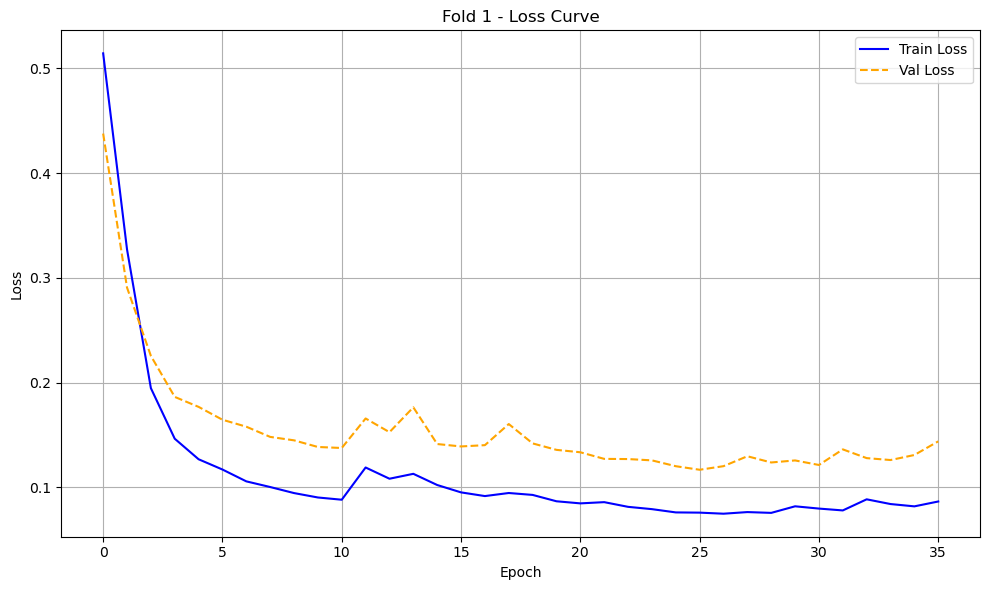

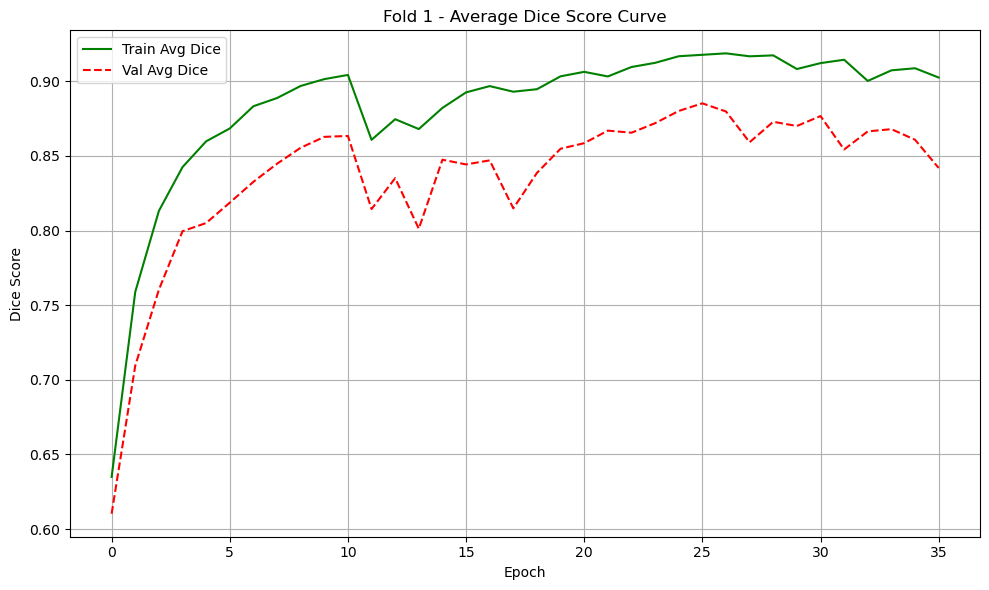

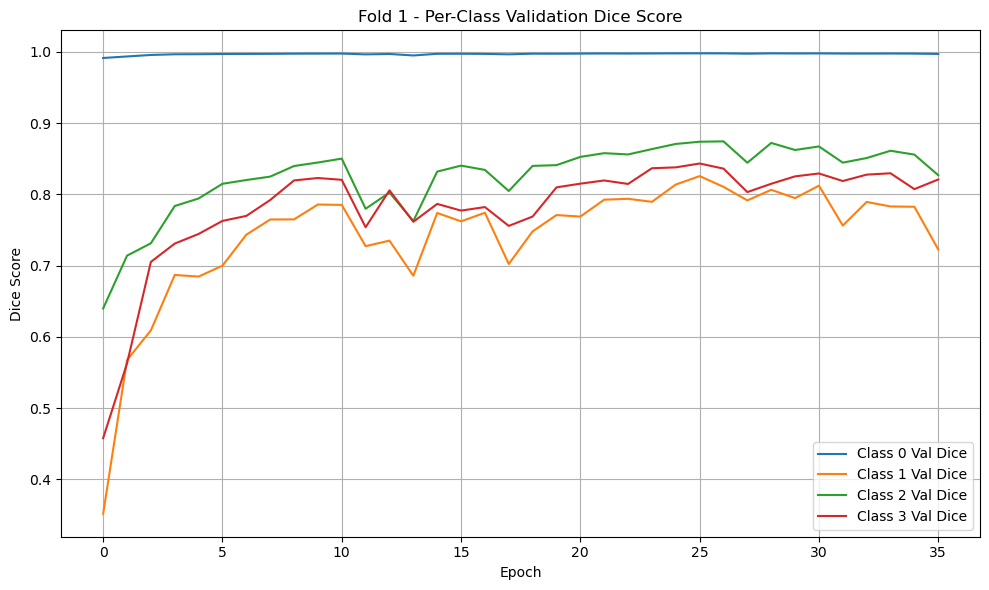


🚀 Fold 2/5
🔁 Resuming Fold 2 from checkpoint...


Val Epoch 3: 100%|██████████| 112/112 [00:05<00:00, 21.02it/s]


📘 Epoch 3: Train Loss=0.1713 | Val Loss=0.2095 | Train Avg Dice=0.8268 | Val Avg Dice=0.7733
🌟 New best model saved!


Val Epoch 4: 100%|██████████| 112/112 [00:05<00:00, 21.55it/s]


📘 Epoch 4: Train Loss=0.1419 | Val Loss=0.2269 | Train Avg Dice=0.8426 | Val Avg Dice=0.7226


Val Epoch 5: 100%|██████████| 112/112 [00:05<00:00, 21.60it/s]


📘 Epoch 5: Train Loss=0.1227 | Val Loss=0.1896 | Train Avg Dice=0.8636 | Val Avg Dice=0.7796
🌟 New best model saved!


Val Epoch 6: 100%|██████████| 112/112 [00:05<00:00, 21.62it/s]


📘 Epoch 6: Train Loss=0.1157 | Val Loss=0.1686 | Train Avg Dice=0.8707 | Val Avg Dice=0.8117
🌟 New best model saved!


Val Epoch 7: 100%|██████████| 112/112 [00:05<00:00, 21.54it/s]


📘 Epoch 7: Train Loss=0.1023 | Val Loss=0.1543 | Train Avg Dice=0.8876 | Val Avg Dice=0.8326
🌟 New best model saved!


Val Epoch 8: 100%|██████████| 112/112 [00:05<00:00, 21.61it/s]


📘 Epoch 8: Train Loss=0.0959 | Val Loss=0.1529 | Train Avg Dice=0.8950 | Val Avg Dice=0.8302
🌟 New best model saved!


Val Epoch 9: 100%|██████████| 112/112 [00:05<00:00, 21.60it/s]


📘 Epoch 9: Train Loss=0.0947 | Val Loss=0.1458 | Train Avg Dice=0.8954 | Val Avg Dice=0.8417
🌟 New best model saved!


Val Epoch 10: 100%|██████████| 112/112 [00:05<00:00, 21.53it/s]


📘 Epoch 10: Train Loss=0.0896 | Val Loss=0.1438 | Train Avg Dice=0.9028 | Val Avg Dice=0.8447
🌟 New best model saved!


Val Epoch 11: 100%|██████████| 112/112 [00:05<00:00, 21.57it/s]


📘 Epoch 11: Train Loss=0.0878 | Val Loss=0.1440 | Train Avg Dice=0.9053 | Val Avg Dice=0.8411


Val Epoch 12: 100%|██████████| 112/112 [00:05<00:00, 21.52it/s]


📘 Epoch 12: Train Loss=0.1163 | Val Loss=0.1665 | Train Avg Dice=0.8644 | Val Avg Dice=0.7979


Val Epoch 13: 100%|██████████| 112/112 [00:05<00:00, 21.57it/s]


📘 Epoch 13: Train Loss=0.1080 | Val Loss=0.1518 | Train Avg Dice=0.8753 | Val Avg Dice=0.8275


Val Epoch 14: 100%|██████████| 112/112 [00:05<00:00, 21.57it/s]


📘 Epoch 14: Train Loss=0.0990 | Val Loss=0.1618 | Train Avg Dice=0.8878 | Val Avg Dice=0.8066


Val Epoch 15: 100%|██████████| 112/112 [00:05<00:00, 21.51it/s]


📘 Epoch 15: Train Loss=0.1061 | Val Loss=0.1557 | Train Avg Dice=0.8778 | Val Avg Dice=0.8205


Val Epoch 16: 100%|██████████| 112/112 [00:05<00:00, 21.58it/s]


📘 Epoch 16: Train Loss=0.0950 | Val Loss=0.1415 | Train Avg Dice=0.8921 | Val Avg Dice=0.8443
🌟 New best model saved!


Val Epoch 17: 100%|██████████| 112/112 [00:05<00:00, 21.63it/s]


📘 Epoch 17: Train Loss=0.0983 | Val Loss=0.1486 | Train Avg Dice=0.8874 | Val Avg Dice=0.8325


Val Epoch 18: 100%|██████████| 112/112 [00:05<00:00, 21.53it/s]


📘 Epoch 18: Train Loss=0.0911 | Val Loss=0.1444 | Train Avg Dice=0.8981 | Val Avg Dice=0.8396


Val Epoch 19: 100%|██████████| 112/112 [00:05<00:00, 21.34it/s]


📘 Epoch 19: Train Loss=0.0899 | Val Loss=0.1516 | Train Avg Dice=0.8995 | Val Avg Dice=0.8270


Val Epoch 20: 100%|██████████| 112/112 [00:05<00:00, 21.50it/s]


📘 Epoch 20: Train Loss=0.0872 | Val Loss=0.1439 | Train Avg Dice=0.9026 | Val Avg Dice=0.8400


Val Epoch 21: 100%|██████████| 112/112 [00:05<00:00, 22.07it/s]


📘 Epoch 21: Train Loss=0.0837 | Val Loss=0.1373 | Train Avg Dice=0.9074 | Val Avg Dice=0.8524
🌟 New best model saved!


Val Epoch 22: 100%|██████████| 112/112 [00:05<00:00, 22.00it/s]


📘 Epoch 22: Train Loss=0.0829 | Val Loss=0.1400 | Train Avg Dice=0.9077 | Val Avg Dice=0.8413


Val Epoch 23: 100%|██████████| 112/112 [00:05<00:00, 21.42it/s]


📘 Epoch 23: Train Loss=0.0791 | Val Loss=0.1274 | Train Avg Dice=0.9136 | Val Avg Dice=0.8607
🌟 New best model saved!


Val Epoch 24: 100%|██████████| 112/112 [00:05<00:00, 21.46it/s]


📘 Epoch 24: Train Loss=0.0810 | Val Loss=0.1379 | Train Avg Dice=0.9109 | Val Avg Dice=0.8467


Val Epoch 25: 100%|██████████| 112/112 [00:05<00:00, 21.48it/s]


📘 Epoch 25: Train Loss=0.0763 | Val Loss=0.1285 | Train Avg Dice=0.9167 | Val Avg Dice=0.8585


Val Epoch 26: 100%|██████████| 112/112 [00:05<00:00, 21.45it/s]


📘 Epoch 26: Train Loss=0.0757 | Val Loss=0.1247 | Train Avg Dice=0.9178 | Val Avg Dice=0.8692
🌟 New best model saved!


Val Epoch 27: 100%|██████████| 112/112 [00:05<00:00, 21.34it/s]


📘 Epoch 27: Train Loss=0.0768 | Val Loss=0.1243 | Train Avg Dice=0.9164 | Val Avg Dice=0.8704
🌟 New best model saved!


Val Epoch 28: 100%|██████████| 112/112 [00:05<00:00, 21.34it/s]


📘 Epoch 28: Train Loss=0.0760 | Val Loss=0.1229 | Train Avg Dice=0.9171 | Val Avg Dice=0.8691
🌟 New best model saved!


Val Epoch 29: 100%|██████████| 112/112 [00:05<00:00, 21.54it/s]


📘 Epoch 29: Train Loss=0.0750 | Val Loss=0.1214 | Train Avg Dice=0.9186 | Val Avg Dice=0.8752
🌟 New best model saved!


Val Epoch 30: 100%|██████████| 112/112 [00:05<00:00, 21.56it/s]


📘 Epoch 30: Train Loss=0.0772 | Val Loss=0.1283 | Train Avg Dice=0.9153 | Val Avg Dice=0.8646


Val Epoch 31: 100%|██████████| 112/112 [00:05<00:00, 21.54it/s]


📘 Epoch 31: Train Loss=0.0796 | Val Loss=0.1256 | Train Avg Dice=0.9122 | Val Avg Dice=0.8586


Val Epoch 32: 100%|██████████| 112/112 [00:05<00:00, 21.46it/s]


📘 Epoch 32: Train Loss=0.0796 | Val Loss=0.1334 | Train Avg Dice=0.9124 | Val Avg Dice=0.8533


Val Epoch 33: 100%|██████████| 112/112 [00:05<00:00, 21.30it/s]


📘 Epoch 33: Train Loss=0.0887 | Val Loss=0.1309 | Train Avg Dice=0.9003 | Val Avg Dice=0.8614


Val Epoch 34: 100%|██████████| 112/112 [00:05<00:00, 21.88it/s]


📘 Epoch 34: Train Loss=0.0856 | Val Loss=0.1322 | Train Avg Dice=0.9045 | Val Avg Dice=0.8564


Val Epoch 35: 100%|██████████| 112/112 [00:05<00:00, 21.23it/s]


📘 Epoch 35: Train Loss=0.0867 | Val Loss=0.1322 | Train Avg Dice=0.9034 | Val Avg Dice=0.8597


Val Epoch 36: 100%|██████████| 112/112 [00:05<00:00, 21.25it/s]


📘 Epoch 36: Train Loss=0.0853 | Val Loss=0.1304 | Train Avg Dice=0.9048 | Val Avg Dice=0.8574


Val Epoch 37: 100%|██████████| 112/112 [00:05<00:00, 21.26it/s]


📘 Epoch 37: Train Loss=0.0880 | Val Loss=0.1297 | Train Avg Dice=0.9013 | Val Avg Dice=0.8606


Val Epoch 38: 100%|██████████| 112/112 [00:05<00:00, 21.26it/s]


📘 Epoch 38: Train Loss=0.0813 | Val Loss=0.1274 | Train Avg Dice=0.9102 | Val Avg Dice=0.8641


Val Epoch 39: 100%|██████████| 112/112 [00:05<00:00, 21.25it/s]


📘 Epoch 39: Train Loss=0.0806 | Val Loss=0.1301 | Train Avg Dice=0.9105 | Val Avg Dice=0.8598
⏹️ Early stopping.
SWA model saved.

📈 Plotting results for Fold 2...


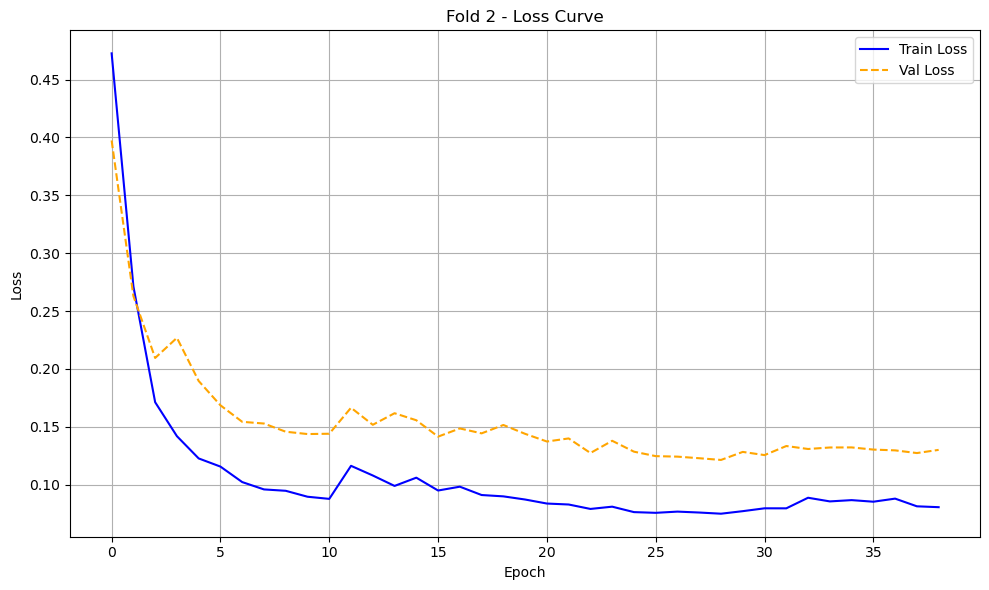

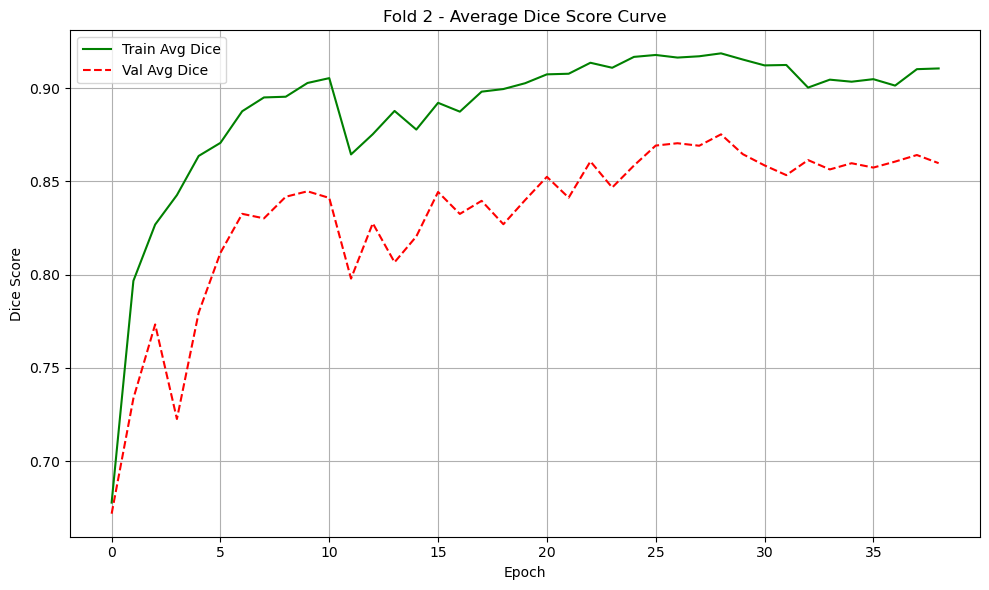

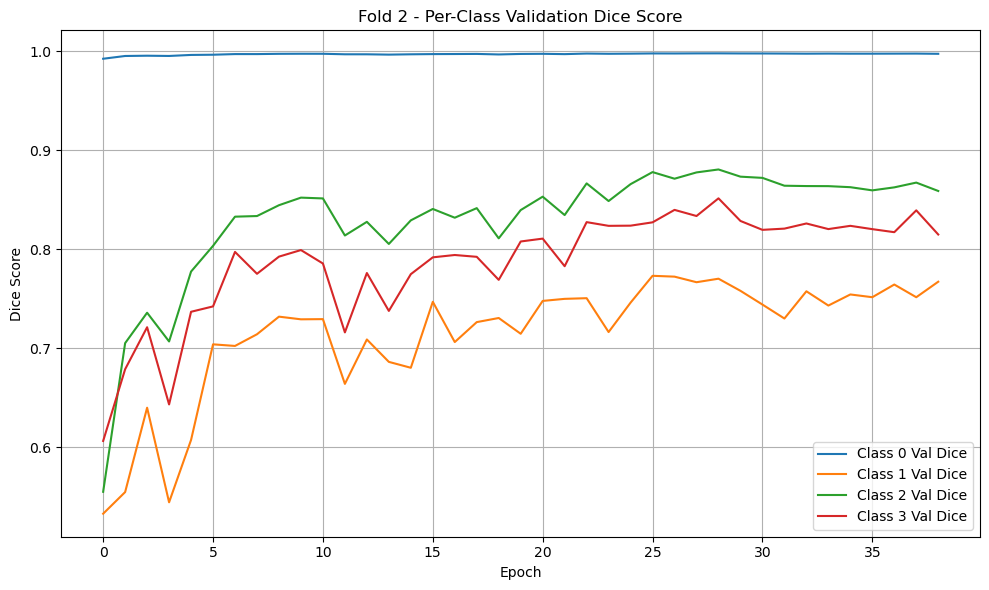


🚀 Fold 3/5
🔁 Resuming Fold 3 from checkpoint...


Val Epoch 3: 100%|██████████| 112/112 [00:05<00:00, 20.70it/s]


📘 Epoch 3: Train Loss=0.2290 | Val Loss=0.2398 | Train Avg Dice=0.8109 | Val Avg Dice=0.7460
🌟 New best model saved!


Val Epoch 4: 100%|██████████| 112/112 [00:05<00:00, 22.18it/s]


📘 Epoch 4: Train Loss=0.1581 | Val Loss=0.2165 | Train Avg Dice=0.8366 | Val Avg Dice=0.7480
🌟 New best model saved!


Val Epoch 5: 100%|██████████| 112/112 [00:05<00:00, 22.12it/s]


📘 Epoch 5: Train Loss=0.1321 | Val Loss=0.1964 | Train Avg Dice=0.8568 | Val Avg Dice=0.7871
🌟 New best model saved!


Val Epoch 6: 100%|██████████| 112/112 [00:05<00:00, 22.18it/s]


📘 Epoch 6: Train Loss=0.1163 | Val Loss=0.1852 | Train Avg Dice=0.8740 | Val Avg Dice=0.7951
🌟 New best model saved!


Val Epoch 7: 100%|██████████| 112/112 [00:05<00:00, 21.55it/s]


📘 Epoch 7: Train Loss=0.1086 | Val Loss=0.1776 | Train Avg Dice=0.8806 | Val Avg Dice=0.8021
🌟 New best model saved!


Val Epoch 8: 100%|██████████| 112/112 [00:05<00:00, 21.53it/s]


📘 Epoch 8: Train Loss=0.1023 | Val Loss=0.1749 | Train Avg Dice=0.8885 | Val Avg Dice=0.8076
🌟 New best model saved!


Val Epoch 9: 100%|██████████| 112/112 [00:05<00:00, 22.14it/s]


📘 Epoch 9: Train Loss=0.0983 | Val Loss=0.1600 | Train Avg Dice=0.8926 | Val Avg Dice=0.8284
🌟 New best model saved!


Val Epoch 10: 100%|██████████| 112/112 [00:05<00:00, 21.99it/s]


📘 Epoch 10: Train Loss=0.0925 | Val Loss=0.1596 | Train Avg Dice=0.9001 | Val Avg Dice=0.8326
🌟 New best model saved!


Val Epoch 11: 100%|██████████| 112/112 [00:05<00:00, 22.23it/s]


📘 Epoch 11: Train Loss=0.0901 | Val Loss=0.1582 | Train Avg Dice=0.9031 | Val Avg Dice=0.8335
🌟 New best model saved!


Val Epoch 12: 100%|██████████| 112/112 [00:05<00:00, 21.54it/s]


📘 Epoch 12: Train Loss=0.1127 | Val Loss=0.1941 | Train Avg Dice=0.8703 | Val Avg Dice=0.7647


Val Epoch 13: 100%|██████████| 112/112 [00:05<00:00, 22.19it/s]


📘 Epoch 13: Train Loss=0.1104 | Val Loss=0.1705 | Train Avg Dice=0.8727 | Val Avg Dice=0.8116


Val Epoch 14: 100%|██████████| 112/112 [00:05<00:00, 21.53it/s]


📘 Epoch 14: Train Loss=0.1029 | Val Loss=0.1649 | Train Avg Dice=0.8838 | Val Avg Dice=0.8137


Val Epoch 15: 100%|██████████| 112/112 [00:05<00:00, 21.53it/s]


📘 Epoch 15: Train Loss=0.0999 | Val Loss=0.1827 | Train Avg Dice=0.8873 | Val Avg Dice=0.7878


Val Epoch 16: 100%|██████████| 112/112 [00:05<00:00, 21.58it/s]


📘 Epoch 16: Train Loss=0.0975 | Val Loss=0.1590 | Train Avg Dice=0.8899 | Val Avg Dice=0.8363


Val Epoch 17: 100%|██████████| 112/112 [00:05<00:00, 21.53it/s]


📘 Epoch 17: Train Loss=0.0967 | Val Loss=0.1589 | Train Avg Dice=0.8908 | Val Avg Dice=0.8284


Val Epoch 18: 100%|██████████| 112/112 [00:05<00:00, 21.42it/s]


📘 Epoch 18: Train Loss=0.0910 | Val Loss=0.1583 | Train Avg Dice=0.8981 | Val Avg Dice=0.8242


Val Epoch 19: 100%|██████████| 112/112 [00:05<00:00, 21.46it/s]


📘 Epoch 19: Train Loss=0.0934 | Val Loss=0.1680 | Train Avg Dice=0.8940 | Val Avg Dice=0.8084


Val Epoch 20: 100%|██████████| 112/112 [00:05<00:00, 21.52it/s]


📘 Epoch 20: Train Loss=0.0905 | Val Loss=0.1497 | Train Avg Dice=0.8991 | Val Avg Dice=0.8391
🌟 New best model saved!


Val Epoch 21: 100%|██████████| 112/112 [00:05<00:00, 21.48it/s]


📘 Epoch 21: Train Loss=0.0854 | Val Loss=0.1495 | Train Avg Dice=0.9056 | Val Avg Dice=0.8351
🌟 New best model saved!


Val Epoch 22: 100%|██████████| 112/112 [00:05<00:00, 21.58it/s]


📘 Epoch 22: Train Loss=0.0836 | Val Loss=0.1461 | Train Avg Dice=0.9076 | Val Avg Dice=0.8449
🌟 New best model saved!


Val Epoch 23: 100%|██████████| 112/112 [00:05<00:00, 21.49it/s]


📘 Epoch 23: Train Loss=0.0835 | Val Loss=0.1394 | Train Avg Dice=0.9070 | Val Avg Dice=0.8586
🌟 New best model saved!


Val Epoch 24: 100%|██████████| 112/112 [00:05<00:00, 21.50it/s]


📘 Epoch 24: Train Loss=0.0808 | Val Loss=0.1380 | Train Avg Dice=0.9118 | Val Avg Dice=0.8618
🌟 New best model saved!


Val Epoch 25: 100%|██████████| 112/112 [00:05<00:00, 21.50it/s]


📘 Epoch 25: Train Loss=0.0781 | Val Loss=0.1436 | Train Avg Dice=0.9143 | Val Avg Dice=0.8533


Val Epoch 26: 100%|██████████| 112/112 [00:05<00:00, 21.50it/s]


📘 Epoch 26: Train Loss=0.0775 | Val Loss=0.1379 | Train Avg Dice=0.9156 | Val Avg Dice=0.8590
🌟 New best model saved!


Val Epoch 27: 100%|██████████| 112/112 [00:05<00:00, 21.45it/s]


📘 Epoch 27: Train Loss=0.0762 | Val Loss=0.1372 | Train Avg Dice=0.9179 | Val Avg Dice=0.8611
🌟 New best model saved!


Val Epoch 28: 100%|██████████| 112/112 [00:05<00:00, 21.46it/s]


📘 Epoch 28: Train Loss=0.0801 | Val Loss=0.1356 | Train Avg Dice=0.9129 | Val Avg Dice=0.8657
🌟 New best model saved!


Val Epoch 29: 100%|██████████| 112/112 [00:05<00:00, 21.50it/s]


📘 Epoch 29: Train Loss=0.0760 | Val Loss=0.1381 | Train Avg Dice=0.9172 | Val Avg Dice=0.8587


Val Epoch 30: 100%|██████████| 112/112 [00:05<00:00, 21.61it/s]


📘 Epoch 30: Train Loss=0.0806 | Val Loss=0.1366 | Train Avg Dice=0.9113 | Val Avg Dice=0.8658


Val Epoch 31: 100%|██████████| 112/112 [00:05<00:00, 21.54it/s]


📘 Epoch 31: Train Loss=0.0787 | Val Loss=0.1364 | Train Avg Dice=0.9141 | Val Avg Dice=0.8662


Val Epoch 32: 100%|██████████| 112/112 [00:05<00:00, 21.43it/s]


📘 Epoch 32: Train Loss=0.0803 | Val Loss=0.1567 | Train Avg Dice=0.9115 | Val Avg Dice=0.8328


Val Epoch 33: 100%|██████████| 112/112 [00:05<00:00, 21.49it/s]


📘 Epoch 33: Train Loss=0.0846 | Val Loss=0.1489 | Train Avg Dice=0.9055 | Val Avg Dice=0.8465


Val Epoch 34: 100%|██████████| 112/112 [00:05<00:00, 21.50it/s]


📘 Epoch 34: Train Loss=0.0914 | Val Loss=0.1533 | Train Avg Dice=0.8972 | Val Avg Dice=0.8354


Val Epoch 35: 100%|██████████| 112/112 [00:05<00:00, 21.49it/s]


📘 Epoch 35: Train Loss=0.0838 | Val Loss=0.1489 | Train Avg Dice=0.9069 | Val Avg Dice=0.8383


Val Epoch 36: 100%|██████████| 112/112 [00:05<00:00, 21.38it/s]


📘 Epoch 36: Train Loss=0.0893 | Val Loss=0.1555 | Train Avg Dice=0.8998 | Val Avg Dice=0.8283


Val Epoch 37: 100%|██████████| 112/112 [00:05<00:00, 21.30it/s]


📘 Epoch 37: Train Loss=0.0819 | Val Loss=0.1373 | Train Avg Dice=0.9090 | Val Avg Dice=0.8640


Val Epoch 38: 100%|██████████| 112/112 [00:05<00:00, 22.10it/s]


📘 Epoch 38: Train Loss=0.0827 | Val Loss=0.1424 | Train Avg Dice=0.9083 | Val Avg Dice=0.8592
⏹️ Early stopping.
SWA model saved.

📈 Plotting results for Fold 3...


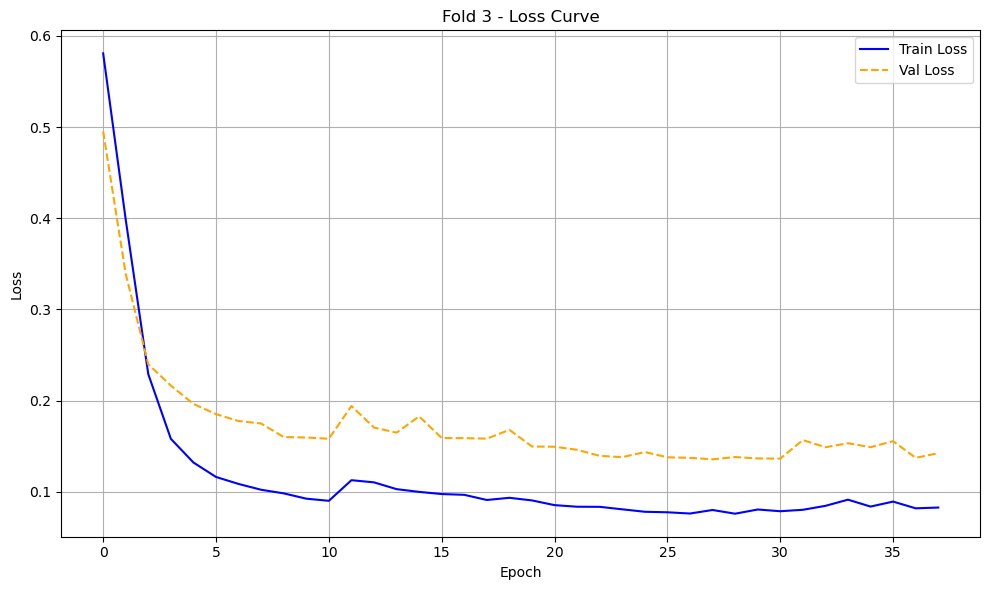

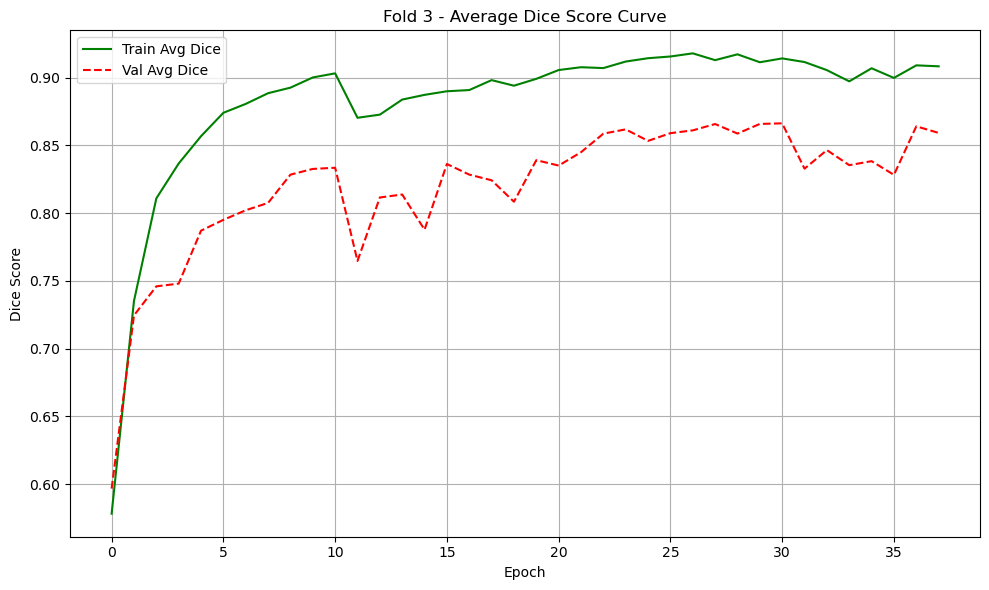

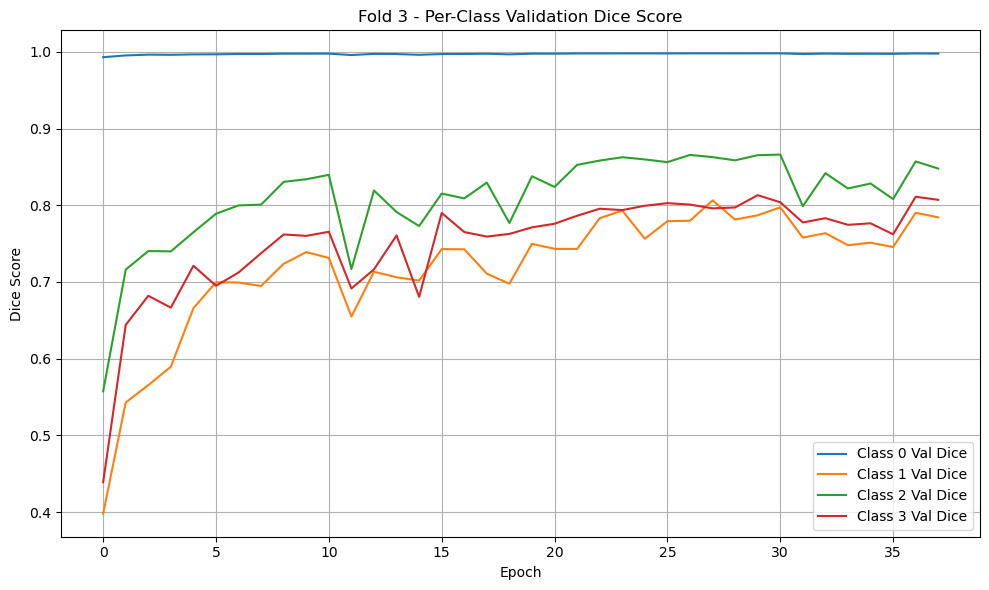


🚀 Fold 4/5
🔁 Resuming Fold 4 from checkpoint...


Val Epoch 3: 100%|██████████| 112/112 [00:05<00:00, 20.59it/s]


📘 Epoch 3: Train Loss=0.1875 | Val Loss=0.2288 | Train Avg Dice=0.8160 | Val Avg Dice=0.7597
🌟 New best model saved!


Val Epoch 4: 100%|██████████| 112/112 [00:05<00:00, 21.36it/s]


📘 Epoch 4: Train Loss=0.1480 | Val Loss=0.1949 | Train Avg Dice=0.8384 | Val Avg Dice=0.7874
🌟 New best model saved!


Val Epoch 5: 100%|██████████| 112/112 [00:05<00:00, 21.91it/s]


📘 Epoch 5: Train Loss=0.1307 | Val Loss=0.1836 | Train Avg Dice=0.8532 | Val Avg Dice=0.7943
🌟 New best model saved!


Val Epoch 6: 100%|██████████| 112/112 [00:05<00:00, 21.48it/s]


📘 Epoch 6: Train Loss=0.1127 | Val Loss=0.1873 | Train Avg Dice=0.8748 | Val Avg Dice=0.7888


Val Epoch 7: 100%|██████████| 112/112 [00:05<00:00, 21.57it/s]


📘 Epoch 7: Train Loss=0.1076 | Val Loss=0.1706 | Train Avg Dice=0.8809 | Val Avg Dice=0.8197
🌟 New best model saved!


Val Epoch 8: 100%|██████████| 112/112 [00:05<00:00, 21.71it/s]


📘 Epoch 8: Train Loss=0.1018 | Val Loss=0.1623 | Train Avg Dice=0.8867 | Val Avg Dice=0.8212
🌟 New best model saved!


Val Epoch 9: 100%|██████████| 112/112 [00:05<00:00, 21.48it/s]


📘 Epoch 9: Train Loss=0.0958 | Val Loss=0.1578 | Train Avg Dice=0.8954 | Val Avg Dice=0.8338
🌟 New best model saved!


Val Epoch 10: 100%|██████████| 112/112 [00:05<00:00, 21.47it/s]


📘 Epoch 10: Train Loss=0.0911 | Val Loss=0.1525 | Train Avg Dice=0.9009 | Val Avg Dice=0.8431
🌟 New best model saved!


Val Epoch 11: 100%|██████████| 112/112 [00:05<00:00, 21.57it/s]


📘 Epoch 11: Train Loss=0.0898 | Val Loss=0.1521 | Train Avg Dice=0.9019 | Val Avg Dice=0.8452
🌟 New best model saved!


Val Epoch 12: 100%|██████████| 112/112 [00:05<00:00, 21.44it/s]


📘 Epoch 12: Train Loss=0.1232 | Val Loss=0.1847 | Train Avg Dice=0.8546 | Val Avg Dice=0.7874


Val Epoch 13: 100%|██████████| 112/112 [00:05<00:00, 21.35it/s]


📘 Epoch 13: Train Loss=0.1127 | Val Loss=0.1752 | Train Avg Dice=0.8692 | Val Avg Dice=0.8065


Val Epoch 14: 100%|██████████| 112/112 [00:05<00:00, 21.41it/s]


📘 Epoch 14: Train Loss=0.1013 | Val Loss=0.1702 | Train Avg Dice=0.8846 | Val Avg Dice=0.8079


Val Epoch 15: 100%|██████████| 112/112 [00:05<00:00, 21.43it/s]


📘 Epoch 15: Train Loss=0.1024 | Val Loss=0.1610 | Train Avg Dice=0.8821 | Val Avg Dice=0.8203


Val Epoch 16: 100%|██████████| 112/112 [00:05<00:00, 21.39it/s]


📘 Epoch 16: Train Loss=0.0980 | Val Loss=0.1593 | Train Avg Dice=0.8895 | Val Avg Dice=0.8229


Val Epoch 17: 100%|██████████| 112/112 [00:05<00:00, 21.37it/s]


📘 Epoch 17: Train Loss=0.0937 | Val Loss=0.1496 | Train Avg Dice=0.8946 | Val Avg Dice=0.8379
🌟 New best model saved!


Val Epoch 18: 100%|██████████| 112/112 [00:05<00:00, 21.35it/s]


📘 Epoch 18: Train Loss=0.1003 | Val Loss=0.1636 | Train Avg Dice=0.8852 | Val Avg Dice=0.8200


Val Epoch 19: 100%|██████████| 112/112 [00:05<00:00, 21.39it/s]


📘 Epoch 19: Train Loss=0.0951 | Val Loss=0.1528 | Train Avg Dice=0.8915 | Val Avg Dice=0.8370


Val Epoch 20: 100%|██████████| 112/112 [00:05<00:00, 21.41it/s]


📘 Epoch 20: Train Loss=0.0902 | Val Loss=0.1489 | Train Avg Dice=0.8980 | Val Avg Dice=0.8398
🌟 New best model saved!


Val Epoch 21: 100%|██████████| 112/112 [00:05<00:00, 21.78it/s]


📘 Epoch 21: Train Loss=0.0852 | Val Loss=0.1429 | Train Avg Dice=0.9050 | Val Avg Dice=0.8528
🌟 New best model saved!


Val Epoch 22: 100%|██████████| 112/112 [00:05<00:00, 21.76it/s]


📘 Epoch 22: Train Loss=0.0825 | Val Loss=0.1389 | Train Avg Dice=0.9092 | Val Avg Dice=0.8574
🌟 New best model saved!


Val Epoch 23: 100%|██████████| 112/112 [00:05<00:00, 21.40it/s]


📘 Epoch 23: Train Loss=0.0832 | Val Loss=0.1392 | Train Avg Dice=0.9072 | Val Avg Dice=0.8559


Val Epoch 24: 100%|██████████| 112/112 [00:05<00:00, 21.26it/s]


📘 Epoch 24: Train Loss=0.0801 | Val Loss=0.1374 | Train Avg Dice=0.9120 | Val Avg Dice=0.8627
🌟 New best model saved!


Val Epoch 25: 100%|██████████| 112/112 [00:05<00:00, 21.98it/s]


📘 Epoch 25: Train Loss=0.0775 | Val Loss=0.1356 | Train Avg Dice=0.9151 | Val Avg Dice=0.8626
🌟 New best model saved!


Val Epoch 26: 100%|██████████| 112/112 [00:05<00:00, 21.34it/s]


📘 Epoch 26: Train Loss=0.0768 | Val Loss=0.1323 | Train Avg Dice=0.9160 | Val Avg Dice=0.8731
🌟 New best model saved!


Val Epoch 27: 100%|██████████| 112/112 [00:05<00:00, 22.06it/s]


📘 Epoch 27: Train Loss=0.0775 | Val Loss=0.1339 | Train Avg Dice=0.9158 | Val Avg Dice=0.8658


Val Epoch 28: 100%|██████████| 112/112 [00:05<00:00, 21.34it/s]


📘 Epoch 28: Train Loss=0.0749 | Val Loss=0.1325 | Train Avg Dice=0.9186 | Val Avg Dice=0.8688


Val Epoch 29: 100%|██████████| 112/112 [00:05<00:00, 21.38it/s]


📘 Epoch 29: Train Loss=0.0755 | Val Loss=0.1341 | Train Avg Dice=0.9179 | Val Avg Dice=0.8690


Val Epoch 30: 100%|██████████| 112/112 [00:05<00:00, 21.37it/s]


📘 Epoch 30: Train Loss=0.0797 | Val Loss=0.1406 | Train Avg Dice=0.9118 | Val Avg Dice=0.8586


Val Epoch 31: 100%|██████████| 112/112 [00:05<00:00, 21.36it/s]


📘 Epoch 31: Train Loss=0.0815 | Val Loss=0.1367 | Train Avg Dice=0.9093 | Val Avg Dice=0.8641


Val Epoch 32: 100%|██████████| 112/112 [00:05<00:00, 21.63it/s]


📘 Epoch 32: Train Loss=0.0852 | Val Loss=0.1491 | Train Avg Dice=0.9041 | Val Avg Dice=0.8404


Val Epoch 33: 100%|██████████| 112/112 [00:05<00:00, 21.96it/s]


📘 Epoch 33: Train Loss=0.0879 | Val Loss=0.1649 | Train Avg Dice=0.9011 | Val Avg Dice=0.8181


Val Epoch 34: 100%|██████████| 112/112 [00:05<00:00, 21.39it/s]


📘 Epoch 34: Train Loss=0.0845 | Val Loss=0.1451 | Train Avg Dice=0.9059 | Val Avg Dice=0.8528


Val Epoch 35: 100%|██████████| 112/112 [00:05<00:00, 21.35it/s]


📘 Epoch 35: Train Loss=0.0871 | Val Loss=0.1385 | Train Avg Dice=0.9023 | Val Avg Dice=0.8550


Val Epoch 36: 100%|██████████| 112/112 [00:05<00:00, 21.37it/s]


📘 Epoch 36: Train Loss=0.0827 | Val Loss=0.1494 | Train Avg Dice=0.9081 | Val Avg Dice=0.8434
⏹️ Early stopping.
SWA model saved.

📈 Plotting results for Fold 4...


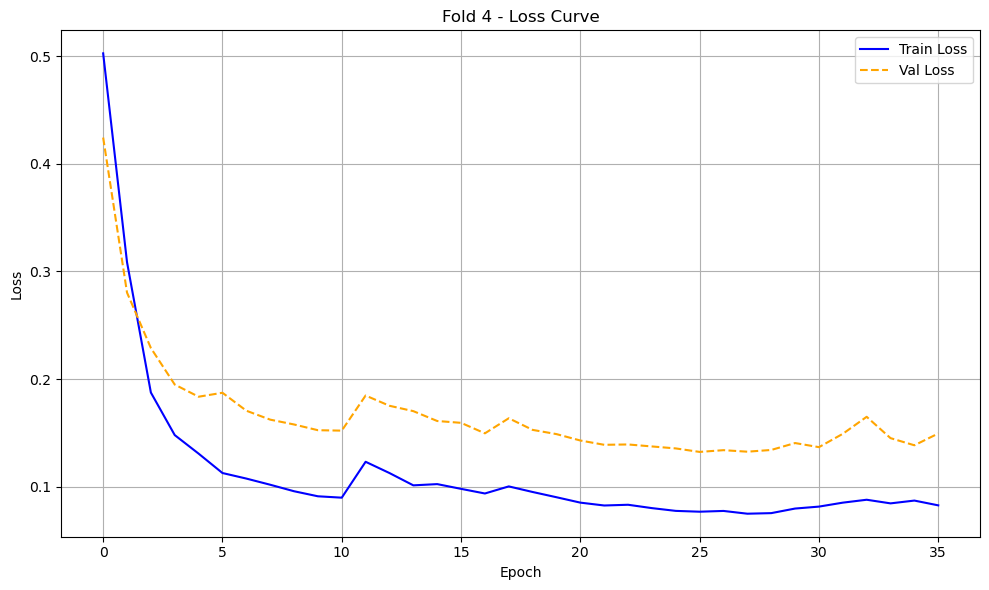

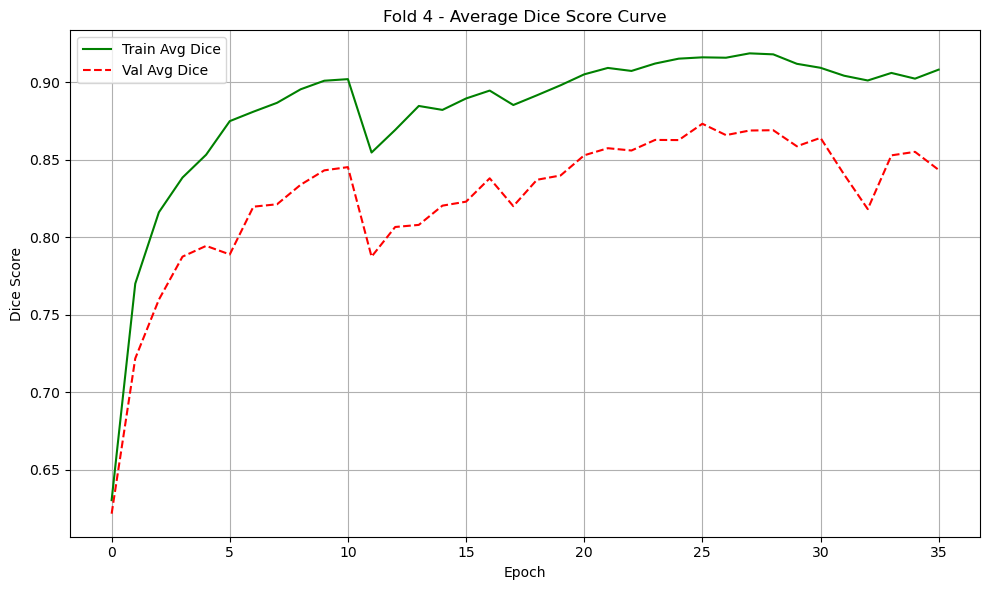

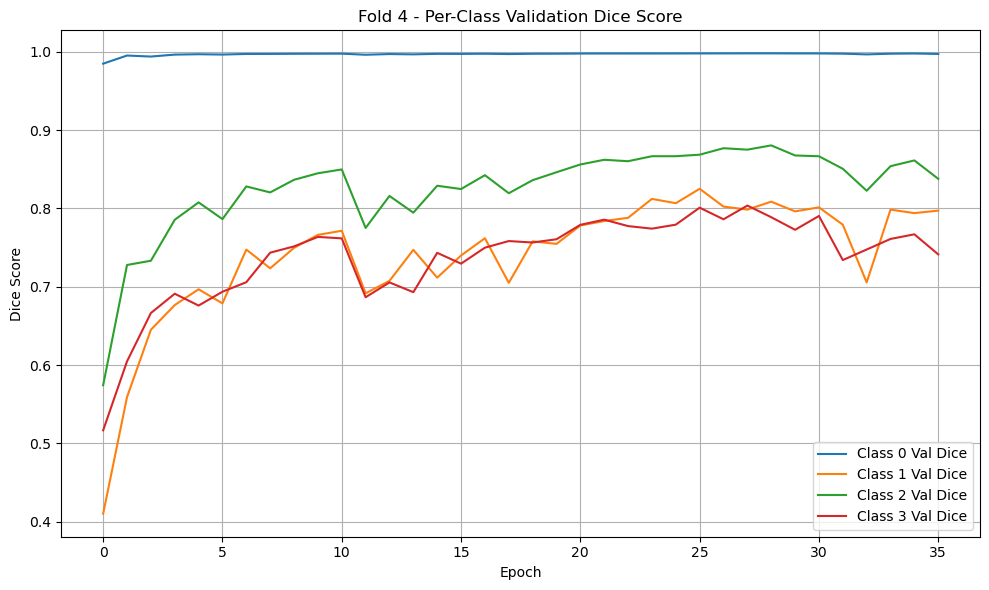


🚀 Fold 5/5
🔁 Resuming Fold 5 from checkpoint...


Val Epoch 3: 100%|██████████| 112/112 [00:05<00:00, 20.89it/s]


📘 Epoch 3: Train Loss=0.2475 | Val Loss=0.2642 | Train Avg Dice=0.7970 | Val Avg Dice=0.7218
🌟 New best model saved!


Val Epoch 4: 100%|██████████| 112/112 [00:05<00:00, 21.65it/s]


📘 Epoch 4: Train Loss=0.1720 | Val Loss=0.2247 | Train Avg Dice=0.8222 | Val Avg Dice=0.7502
🌟 New best model saved!


Val Epoch 5: 100%|██████████| 112/112 [00:05<00:00, 21.76it/s]


📘 Epoch 5: Train Loss=0.1378 | Val Loss=0.1917 | Train Avg Dice=0.8516 | Val Avg Dice=0.7980
🌟 New best model saved!


Val Epoch 6: 100%|██████████| 112/112 [00:05<00:00, 21.63it/s]


📘 Epoch 6: Train Loss=0.1250 | Val Loss=0.1807 | Train Avg Dice=0.8620 | Val Avg Dice=0.8025
🌟 New best model saved!


Val Epoch 7: 100%|██████████| 112/112 [00:05<00:00, 21.73it/s]


📘 Epoch 7: Train Loss=0.1128 | Val Loss=0.1709 | Train Avg Dice=0.8751 | Val Avg Dice=0.8266
🌟 New best model saved!


Val Epoch 8: 100%|██████████| 112/112 [00:05<00:00, 21.59it/s]


📘 Epoch 8: Train Loss=0.1049 | Val Loss=0.1613 | Train Avg Dice=0.8847 | Val Avg Dice=0.8339
🌟 New best model saved!


Val Epoch 9: 100%|██████████| 112/112 [00:05<00:00, 21.59it/s]


📘 Epoch 9: Train Loss=0.0989 | Val Loss=0.1560 | Train Avg Dice=0.8923 | Val Avg Dice=0.8429
🌟 New best model saved!


Val Epoch 10: 100%|██████████| 112/112 [00:05<00:00, 21.58it/s]


📘 Epoch 10: Train Loss=0.0960 | Val Loss=0.1536 | Train Avg Dice=0.8948 | Val Avg Dice=0.8473
🌟 New best model saved!


Val Epoch 11: 100%|██████████| 112/112 [00:05<00:00, 21.55it/s]


📘 Epoch 11: Train Loss=0.0928 | Val Loss=0.1512 | Train Avg Dice=0.8992 | Val Avg Dice=0.8501
🌟 New best model saved!


Val Epoch 12: 100%|██████████| 112/112 [00:05<00:00, 21.71it/s]


📘 Epoch 12: Train Loss=0.1196 | Val Loss=0.1730 | Train Avg Dice=0.8616 | Val Avg Dice=0.8122


Val Epoch 13: 100%|██████████| 112/112 [00:05<00:00, 21.57it/s]


📘 Epoch 13: Train Loss=0.1112 | Val Loss=0.1731 | Train Avg Dice=0.8710 | Val Avg Dice=0.8216


Val Epoch 14: 100%|██████████| 112/112 [00:05<00:00, 21.55it/s]


📘 Epoch 14: Train Loss=0.1034 | Val Loss=0.1685 | Train Avg Dice=0.8828 | Val Avg Dice=0.8210


Val Epoch 15: 100%|██████████| 112/112 [00:05<00:00, 21.59it/s]


📘 Epoch 15: Train Loss=0.1087 | Val Loss=0.2727 | Train Avg Dice=0.8750 | Val Avg Dice=0.6562


Val Epoch 16: 100%|██████████| 112/112 [00:05<00:00, 21.56it/s]


📘 Epoch 16: Train Loss=0.1101 | Val Loss=0.1621 | Train Avg Dice=0.8719 | Val Avg Dice=0.8327


Val Epoch 17: 100%|██████████| 112/112 [00:05<00:00, 21.61it/s]


📘 Epoch 17: Train Loss=0.0981 | Val Loss=0.1629 | Train Avg Dice=0.8893 | Val Avg Dice=0.8303


Val Epoch 18: 100%|██████████| 112/112 [00:05<00:00, 21.51it/s]


📘 Epoch 18: Train Loss=0.0957 | Val Loss=0.1542 | Train Avg Dice=0.8906 | Val Avg Dice=0.8459


Val Epoch 19: 100%|██████████| 112/112 [00:05<00:00, 21.50it/s]


📘 Epoch 19: Train Loss=0.0934 | Val Loss=0.1555 | Train Avg Dice=0.8939 | Val Avg Dice=0.8418


Val Epoch 20: 100%|██████████| 112/112 [00:05<00:00, 21.57it/s]


📘 Epoch 20: Train Loss=0.0899 | Val Loss=0.1469 | Train Avg Dice=0.9000 | Val Avg Dice=0.8553
🌟 New best model saved!


Val Epoch 21: 100%|██████████| 112/112 [00:05<00:00, 21.64it/s]


📘 Epoch 21: Train Loss=0.0871 | Val Loss=0.1489 | Train Avg Dice=0.9036 | Val Avg Dice=0.8501


Val Epoch 22: 100%|██████████| 112/112 [00:05<00:00, 21.43it/s]


📘 Epoch 22: Train Loss=0.0854 | Val Loss=0.1418 | Train Avg Dice=0.9055 | Val Avg Dice=0.8586
🌟 New best model saved!


Val Epoch 23: 100%|██████████| 112/112 [00:05<00:00, 21.51it/s]


📘 Epoch 23: Train Loss=0.0825 | Val Loss=0.1427 | Train Avg Dice=0.9087 | Val Avg Dice=0.8589


Val Epoch 24: 100%|██████████| 112/112 [00:05<00:00, 21.54it/s]


📘 Epoch 24: Train Loss=0.0789 | Val Loss=0.1370 | Train Avg Dice=0.9138 | Val Avg Dice=0.8717
🌟 New best model saved!


Val Epoch 25: 100%|██████████| 112/112 [00:05<00:00, 21.31it/s]


📘 Epoch 25: Train Loss=0.0808 | Val Loss=0.1369 | Train Avg Dice=0.9101 | Val Avg Dice=0.8685
🌟 New best model saved!


Val Epoch 26: 100%|██████████| 112/112 [00:05<00:00, 21.35it/s]


📘 Epoch 26: Train Loss=0.0766 | Val Loss=0.1359 | Train Avg Dice=0.9165 | Val Avg Dice=0.8707
🌟 New best model saved!


Val Epoch 27: 100%|██████████| 112/112 [00:05<00:00, 21.41it/s]


📘 Epoch 27: Train Loss=0.0775 | Val Loss=0.1302 | Train Avg Dice=0.9148 | Val Avg Dice=0.8826
🌟 New best model saved!


Val Epoch 28: 100%|██████████| 112/112 [00:05<00:00, 21.39it/s]


📘 Epoch 28: Train Loss=0.0798 | Val Loss=0.1361 | Train Avg Dice=0.9129 | Val Avg Dice=0.8657


Val Epoch 29: 100%|██████████| 112/112 [00:05<00:00, 21.31it/s]


📘 Epoch 29: Train Loss=0.0784 | Val Loss=0.1339 | Train Avg Dice=0.9143 | Val Avg Dice=0.8692


Val Epoch 30: 100%|██████████| 112/112 [00:05<00:00, 21.41it/s]


📘 Epoch 30: Train Loss=0.0787 | Val Loss=0.1441 | Train Avg Dice=0.9148 | Val Avg Dice=0.8513


Val Epoch 31: 100%|██████████| 112/112 [00:05<00:00, 21.34it/s]


📘 Epoch 31: Train Loss=0.0844 | Val Loss=0.1472 | Train Avg Dice=0.9059 | Val Avg Dice=0.8479


Val Epoch 32: 100%|██████████| 112/112 [00:05<00:00, 21.33it/s]


📘 Epoch 32: Train Loss=0.0830 | Val Loss=0.1454 | Train Avg Dice=0.9079 | Val Avg Dice=0.8522


Val Epoch 33: 100%|██████████| 112/112 [00:05<00:00, 21.54it/s]


📘 Epoch 33: Train Loss=0.0878 | Val Loss=0.1355 | Train Avg Dice=0.9022 | Val Avg Dice=0.8702


Val Epoch 34: 100%|██████████| 112/112 [00:05<00:00, 21.27it/s]


📘 Epoch 34: Train Loss=0.0834 | Val Loss=0.1402 | Train Avg Dice=0.9074 | Val Avg Dice=0.8608


Val Epoch 35: 100%|██████████| 112/112 [00:05<00:00, 21.32it/s]


📘 Epoch 35: Train Loss=0.0868 | Val Loss=0.1646 | Train Avg Dice=0.9029 | Val Avg Dice=0.8293


Val Epoch 36: 100%|██████████| 112/112 [00:05<00:00, 21.34it/s]


📘 Epoch 36: Train Loss=0.0861 | Val Loss=0.1413 | Train Avg Dice=0.9039 | Val Avg Dice=0.8631


Val Epoch 37: 100%|██████████| 112/112 [00:05<00:00, 21.36it/s]


📘 Epoch 37: Train Loss=0.0816 | Val Loss=0.1349 | Train Avg Dice=0.9098 | Val Avg Dice=0.8704
⏹️ Early stopping.
SWA model saved.

📈 Plotting results for Fold 5...


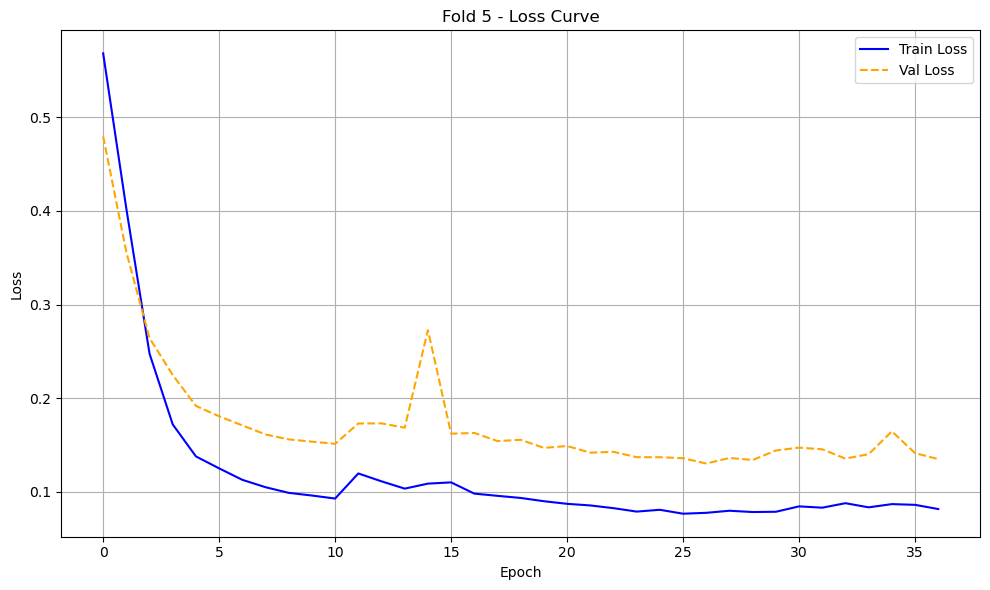

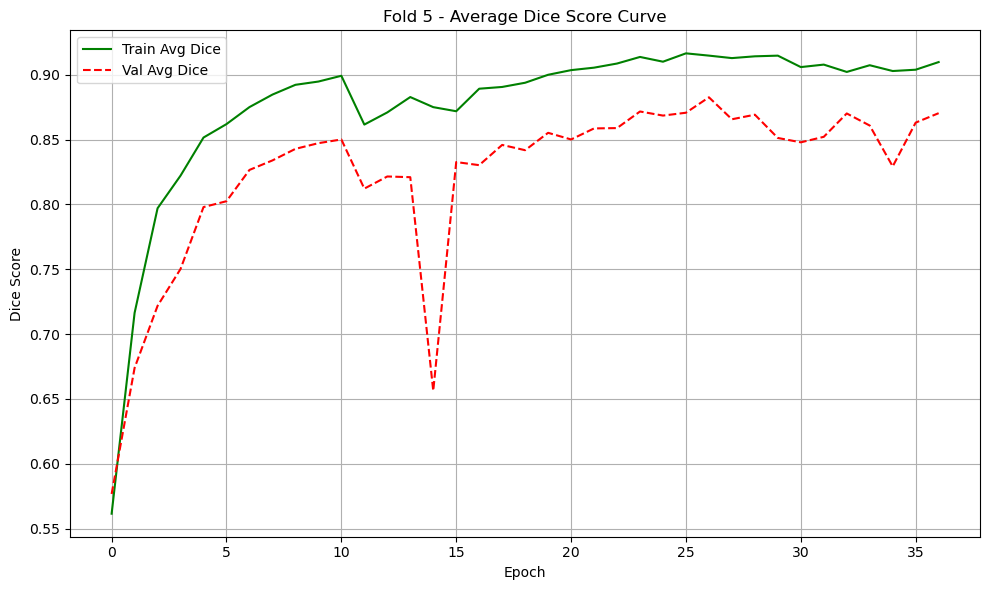

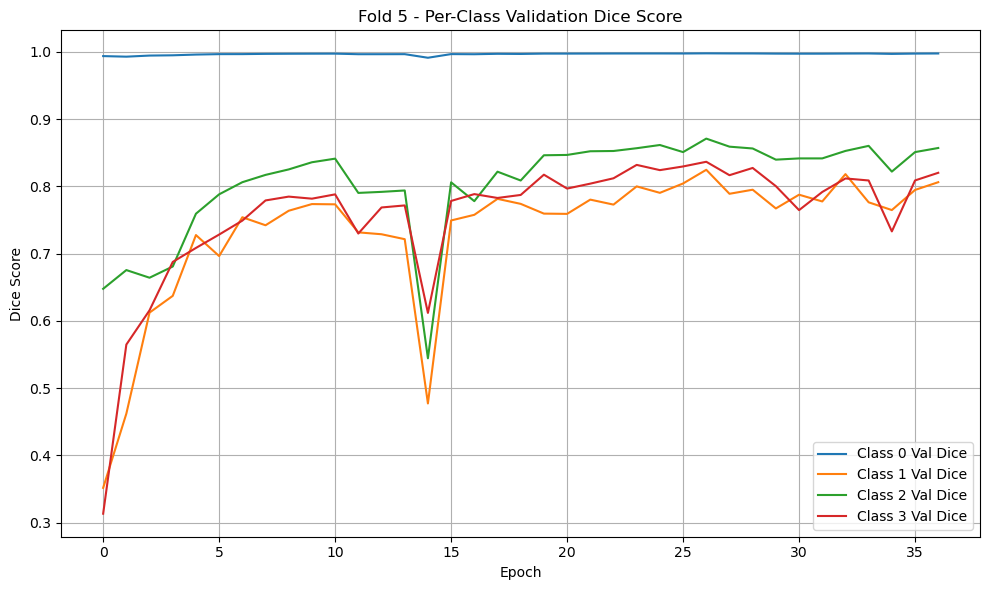


✅ Done. Final Average Validation Dice Scores per Fold: ['0.8420', '0.8598', '0.8592', '0.8434', '0.8704']
📊 Mean Average Validation Dice Score across all folds: 0.8549378337523723
K-Fold training initiated.
train_kfold function loaded.


In [14]:
# --- AttentionUNet Model Definition ---
class AttentionUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Helper convolutional block
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.middle = conv_block(256, 512) # Bottleneck layer
        self.up2 = conv_block(512 + 256, 256) # Concatenated channels from upsampled and skip connection
        self.up1 = conv_block(256 + 128, 128)
        self.up0 = conv_block(128 + 64, 64)
        self.final = nn.Conv2d(64, out_channels, kernel_size=1) # Output layer
        self.pool = nn.MaxPool2d(2) # Downsampling
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # Upsampling

    def forward(self, x):
        # Encoder pathway
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        m = self.middle(self.pool(e3)) # Bottleneck

        # Decoder pathway (with skip connections and upsampling)
        d2 = self.up2(torch.cat([self.up(m), e3], dim=1)) # Upsample bottleneck, concatenate with e3
        d1 = self.up1(torch.cat([self.up(d2), e2], dim=1)) # Upsample d2, concatenate with e2
        d0 = self.up0(torch.cat([self.up(d1), e1], dim=1)) # Upsample d1, concatenate with e1

        return self.final(d0)

print("AttentionUNet model definition (standard U-Net) loaded.")

# --- Prediction Saving Utility ---
def save_prediction_nii(pred_mask, affine, save_path):
    """
    Saves a predicted mask tensor as a NIfTI file.
    Args:
        pred_mask (torch.Tensor): The predicted mask tensor (HxW or DxHxW).
        affine (np.ndarray): The affine transformation matrix for the NIfTI image.
                              Typically, you'd get this from the original NIfTI header.
                              Using np.eye(4) if not available for a generic affine.
        save_path (str): The full path including filename to save the NIfTI file (e.g., 'output.nii.gz').
    """
    pred_np = pred_mask.cpu().numpy().astype(np.uint8)
    # Ensure pred_np is 3D if it's 2D (for a single slice prediction saved as a volume)
    if pred_np.ndim == 2:
        pred_np = pred_np[np.newaxis, :, :] # Add a depth dimension if it's just HxW

    pred_nii = nib.Nifti1Image(pred_np, affine)
    nib.save(pred_nii, save_path)
    # print(f"Saved prediction to: {save_path}") # Uncomment for verbose saving

# --- Loss Functions ---
ce_loss_fn = nn.CrossEntropyLoss()

def multiclass_dice(preds, targets, smooth=1e-5):
    """
    Calculates the multi-class Dice loss.
    Args:
        preds (torch.Tensor): Model predictions (logits) of shape (N, C, H, W).
        targets (torch.Tensor): Ground truth masks of shape (N, H, W).
        smooth (float): Smoothing factor to prevent division by zero.
    Returns:
        torch.Tensor: The averaged Dice loss over all classes.
    """
    num_classes = preds.shape[1]
    preds = F.softmax(preds, dim=1) # Convert logits to probabilities
    total_dice_loss = 0.0
    for c in range(num_classes):
        # Flatten predictions and targets for current class
        pred_flat = preds[:, c].contiguous().view(-1)
        target_flat = (targets == c).float().view(-1)

        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
        total_dice_loss += (1 - dice) # Dice Loss is 1 - Dice Score
    return total_dice_loss / num_classes

def multiclass_ftv(preds, targets, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-5):
    """
    Calculates the multi-class Focal Tversky Loss (FTV).
    Args:
        preds (torch.Tensor): Model predictions (logits) of shape (N, C, H, W).
        targets (torch.Tensor): Ground truth masks of shape (N, H, W).
        alpha (float): Weight for False Positives.
        beta (float): Weight for False Negatives.
        gamma (float): Focusing parameter for Focal Loss.
        smooth (float): Smoothing factor.
    Returns:
        torch.Tensor: The averaged FTV loss over all classes.
    """
    num_classes = preds.shape[1]
    preds = F.softmax(preds, dim=1) # Convert logits to probabilities
    ftv_loss = 0.0
    for c in range(num_classes):
        pred_flat = preds[:, c].contiguous().view(-1)
        target_flat = (targets == c).float().view(-1)

        TP = (pred_flat * target_flat).sum()
        FP = ((1 - target_flat) * pred_flat).sum()
        FN = (target_flat * (1 - pred_flat)).sum()

        tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
        ftv_loss += (1 - tversky) ** gamma # Focal Tversky Loss component
    return ftv_loss / num_classes

def multiclass_boundary(preds, targets):
    """
    Calculates a multi-class boundary loss using Laplacian filter.
    Encourages predicted boundaries to align with ground truth boundaries.
    Args:
        preds (torch.Tensor): Model predictions (logits) of shape (N, C, H, W).
        targets (torch.Tensor): Ground truth masks of shape (N, H, W).
    Returns:
        torch.Tensor: The averaged boundary loss over all classes.
    """
    preds = F.softmax(preds, dim=1) # Convert logits to probabilities
    # Laplacian filter for edge detection
    laplacian = torch.tensor([[-1, -1, -1],
                              [-1,  8, -1],
                              [-1, -1, -1]], dtype=torch.float32, device=preds.device).unsqueeze(0).unsqueeze(0)
    loss = 0.0
    for c in range(preds.shape[1]):
        # Apply Laplacian to prediction and target for current class
        pred_edge = F.conv2d(preds[:, c:c+1], laplacian, padding=1)
        target_edge = F.conv2d((targets == c).float().unsqueeze(1), laplacian, padding=1)
        loss += F.l1_loss(pred_edge, target_edge) # L1 loss between edge maps
    return loss / preds.shape[1]

def full_loss(preds, targets):
    """
    Combines Cross-Entropy, Dice, Focal Tversky, and Boundary losses.
    Args:
        preds (torch.Tensor): Model predictions (logits).
        targets (torch.Tensor): Ground truth masks.
    Returns:
        tuple: (total_loss, dice_loss_val, ftv_loss_val, boundary_loss_val, ce_loss_val)
    """
    ce = ce_loss_fn(preds, targets) if USE_CE else torch.tensor(0.0).to(preds.device)
    d_loss = multiclass_dice(preds, targets)
    ft_loss = multiclass_ftv(preds, targets)
    b_loss = multiclass_boundary(preds, targets)

    # Weights for each loss component
    total = 0.3 * d_loss + 0.3 * ft_loss + 0.2 * b_loss + (0.2 * ce if USE_CE else 0.0)
    return total, d_loss.item(), ft_loss.item(), b_loss.item(), ce.item() if USE_CE else 0.0

# --- Evaluation Metrics ---
def dice_per_class(preds, targets, num_classes, smooth=1e-5):
    """
    Calculates the Dice score for each class.
    Args:
        preds (torch.Tensor): Model predictions (logits) of shape (N, C, H, W).
        targets (torch.Tensor): Ground truth masks of shape (N, H, W).
        num_classes (int): Number of segmentation classes.
        smooth (float): Smoothing factor.
    Returns:
        list: A list of Dice scores, one for each class.
    """
    # Convert predictions to class labels
    preds = torch.argmax(F.softmax(preds, dim=1), dim=1)
    dice_scores = []
    for c in range(num_classes):
        pred_c = (preds == c).float()
        target_c = (targets == c).float()

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())
    return dice_scores

# --- PLOTTING FUNCTION: After each fold (uses plt.pause for non-blocking) ---
def plot_fold_metrics(fold_num, train_losses, val_losses, avg_train_dice, avg_val_dice, per_class_val_dice_dict):
    """
    Plots the loss and Dice curves for a given fold.
    Args:
        fold_num (int): The current fold number (0-indexed).
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch.
        avg_train_dice (list): List of average training Dice scores per epoch.
        avg_val_dice (list): List of average validation Dice scores per epoch.
        per_class_val_dice_dict (dict): Dictionary where keys are class IDs and
                                        values are lists of per-class validation Dice scores per epoch.
    """
    print(f"\n📈 Plotting results for Fold {fold_num + 1}...")

    # Plot Loss Curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label=f'Train Loss', color='blue')
    plt.plot(val_losses, label=f'Val Loss', color='orange', linestyle='--')
    plt.title(f'Fold {fold_num + 1} - Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.pause(0.1) # Non-blocking show for Jupyter

    # Plot Average Dice Curve
    plt.figure(figsize=(10, 6))
    plt.plot(avg_train_dice, label=f'Train Avg Dice', color='green')
    plt.plot(avg_val_dice, label=f'Val Avg Dice', color='red', linestyle='--')
    plt.title(f'Fold {fold_num + 1} - Average Dice Score Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.pause(0.1) # Non-blocking show

    # Plot Per-Class Validation Dice (if you have NUM_CLASSES > 1)
    if NUM_CLASSES > 1:
        plt.figure(figsize=(10, 6))
        for c in range(NUM_CLASSES):
            if c in per_class_val_dice_dict and per_class_val_dice_dict[c]:
                plt.plot(per_class_val_dice_dict[c], label=f'Class {c} Val Dice')
        plt.title(f'Fold {fold_num + 1} - Per-Class Validation Dice Score')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Score')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.pause(0.1) # Non-blocking show

# --- K-Fold Training Loop ---
def train_kfold(dataset, model_class, save_dir, folds=5, patience=10):
    """
    Performs K-Fold cross-validation training for a segmentation model.
    Args:
        dataset (torch.utils.data.Dataset): The full dataset.
        model_class (nn.Module): The class of the model to be trained (e.g., AttentionUNet).
        save_dir (str): Directory to save checkpoints and TensorBoard logs.
        folds (int): Number of folds for K-Fold cross-validation.
        patience (int): Number of epochs to wait for improvement before early stopping.
    """
    kfold = KFold(n_splits=folds, shuffle=True, random_state=42)

    # These lists will store the FINAL average dice per fold for an overall summary at the end
    all_fold_final_avg_val_dice = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\n🚀 Fold {fold+1}/{folds}")
        fold_ckpt_dir = os.path.join(save_dir, f"fold{fold+1}")
        os.makedirs(fold_ckpt_dir, exist_ok=True)
        writer = SummaryWriter(log_dir=fold_ckpt_dir)

        # Ensure that Subset passes through the dataset that already has the TransformedDataset logic
        # If dataset is already TransformedDataset, then no need for new TransformedDataset
        # The split applies to the underlying full_dataset, so we need to re-wrap with transforms for each loader
        # This setup assumes `dataset` passed to `train_kfold` is `full_dataset` (the raw BraTSSliceDataset)
        # And we apply `TransformedDataset` for each fold's train/val loader.
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_dataset_transformed = TransformedDataset(train_subset, get_train_transforms())
        val_dataset_transformed = TransformedDataset(val_subset, get_val_transforms())


        train_loader = DataLoader(train_dataset_transformed, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, persistent_workers=True)
        val_loader = DataLoader(val_dataset_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, persistent_workers=True)

        # Initialize model, optimizer, schedulers
        # Note: New AttentionUNet expects (in_channels, out_channels), no dropout_rate
        model = model_class(IMG_CHANNELS, NUM_CLASSES).to(DEVICE)
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        
        # SWA setup
        swa_model = AveragedModel(model)
        swa_start = NUM_EPOCHS // 2 # Start SWA averaging after half of the epochs
        swa_scheduler = SWALR(optimizer, swa_lr=1e-4) # SWA learning rate scheduler

        start_epoch = 0
        train_losses = []
        val_losses = []
        avg_train_dice_per_epoch = [] # Stores average Dice for training per epoch
        avg_val_dice_per_epoch = []   # Stores average Dice for validation per epoch
        per_class_val_dice_dict = {i: [] for i in range(NUM_CLASSES)} # Stores per-class Dice for validation

        # Resume from checkpoint if available
        resume_path = os.path.join(fold_ckpt_dir, "resume_checkpoint.pth")
        if os.path.exists(resume_path):
            print(f"🔁 Resuming Fold {fold+1} from checkpoint...")
            checkpoint = torch.load(resume_path, map_location=DEVICE, weights_only=False)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            train_losses = checkpoint.get('train_losses', [])
            val_losses = checkpoint.get('val_losses', [])
            per_class_val_dice_dict = checkpoint.get('per_class_dice_dict', {i: [] for i in range(NUM_CLASSES)})
            avg_train_dice_per_epoch = checkpoint.get('avg_train_dice_per_epoch', [])
            avg_val_dice_per_epoch = checkpoint.get('avg_val_dice_per_epoch', [])

            # Reconstruct average dice lists if they weren't explicitly saved (or if lists are empty after loading)
            if not avg_train_dice_per_epoch and train_losses:
                # This assumes train_losses has an entry for each epoch already trained
                avg_train_dice_per_epoch = [0.0] * len(train_losses) # Placeholder if not precisely logged per batch
            if not avg_val_dice_per_epoch and val_losses and per_class_val_dice_dict:
                # Calculate average from per_class_val_dice_dict if available
                avg_val_dice_per_epoch = [
                    np.mean([per_class_val_dice_dict[c][e] for c in range(NUM_CLASSES) if e < len(per_class_val_dice_dict[c])])
                    for e in range(len(val_losses))
                ]

        best_val_loss = float('inf')
        no_improve = 0

        for epoch in range(start_epoch, NUM_EPOCHS):
            model.train()
            epoch_train_loss = 0
            current_epoch_train_dices_per_class = {i: [] for i in range(NUM_CLASSES)}

            for imgs, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
                imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).long()
                optimizer.zero_grad()
                preds = model(imgs)

                # NaN check for predictions
                if torch.isnan(preds).any():
                    print("❌ NaN detected in predictions. Aborting training for this fold.")
                    return # Exit the function, stopping training for this fold

                loss, _, _, _, _ = full_loss(preds, masks)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

                batch_train_dice_scores = dice_per_class(preds, masks, NUM_CLASSES)
                for c, d in enumerate(batch_train_dice_scores):
                    current_epoch_train_dices_per_class[c].append(d)

            train_losses.append(epoch_train_loss / len(train_loader))
            # Calculate average training dice for the epoch
            avg_train_dice_per_epoch.append(np.mean([np.mean(current_epoch_train_dices_per_class[c]) for c in range(NUM_CLASSES)]))

            # Step learning rate schedulers
            if epoch >= swa_start:
                swa_model.update_parameters(model) # Update SWA model
                swa_scheduler.step()
            else:
                scheduler.step()

            # Validation phase
            model.eval()
            epoch_val_loss = 0
            current_epoch_val_dices_per_class = {i: [] for i in range(NUM_CLASSES)}

            with torch.no_grad():
                for i, (imgs, masks) in enumerate(tqdm(val_loader, desc=f"Val Epoch {epoch+1}")):
                    imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).long()
                    preds = model(imgs)
                    loss, _, _, _, _ = full_loss(preds, masks)
                    epoch_val_loss += loss.item()
                    dice_scores = dice_per_class(preds, masks, NUM_CLASSES)
                    for c, d in enumerate(dice_scores):
                        current_epoch_val_dices_per_class[c].append(d)

                    # Save NIfTI predictions for a few samples (optional, can be very disk intensive)
                    # Consider saving only for certain epochs or fewer samples
                    # For a 2D U-Net, if saving 3D NIfTI, you might need to reconstruct the volume
                    # Here, it saves each 2D slice as a 3D NIfTI volume of depth 1, which is fine
                    pred_labels = torch.argmax(F.softmax(preds, dim=1), dim=1)
                    for j in range(pred_labels.shape[0]): # Iterate through batch samples
                        # Using np.eye(4) as a placeholder for affine. For proper NIfTI saving,
                        # the true affine from the original image should be passed from your dataset.
                        save_path = os.path.join(fold_ckpt_dir, f"val_pred_epoch{epoch+1}_sample{i*BATCH_SIZE+j}.nii.gz")
                        # Adjust save_prediction_nii to handle 2D input and make it 3D (HxW -> 1xHxW)
                        save_prediction_nii(pred_labels[j], affine=np.eye(4), save_path=save_path)


            val_losses.append(epoch_val_loss / len(val_loader))

            # Calculate average validation dice for the epoch
            avg_val_dice_for_this_epoch = np.mean([np.mean(current_epoch_val_dices_per_class[c]) for c in range(NUM_CLASSES)])
            avg_val_dice_per_epoch.append(avg_val_dice_for_this_epoch)

            # Store per-class validation dice for plotting
            for c in range(NUM_CLASSES):
                per_class_val_dice_dict[c].append(np.mean(current_epoch_val_dices_per_class[c]))


            # Log to TensorBoard
            writer.add_scalar("Loss/Train", train_losses[-1], epoch)
            writer.add_scalar("Loss/Val", val_losses[-1], epoch)
            writer.add_scalar("Dice/Train_Avg", avg_train_dice_per_epoch[-1], epoch)
            writer.add_scalar("Dice/Val_Avg", avg_val_dice_per_epoch[-1], epoch)
            for c in range(NUM_CLASSES):
                writer.add_scalar(f"Dice/Val_Class_{c}", per_class_val_dice_dict[c][-1], epoch)


            print(f"📘 Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f} | Val Loss={val_losses[-1]:.4f} | Train Avg Dice={avg_train_dice_per_epoch[-1]:.4f} | Val Avg Dice={avg_val_dice_per_epoch[-1]:.4f}")

            # Early stopping and best model saving
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                no_improve = 0
                torch.save(model.state_dict(), os.path.join(fold_ckpt_dir, "best_model.pth"))
                print("🌟 New best model saved!")
            else:
                no_improve += 1
                if no_improve >= patience:
                    print("⏹️ Early stopping.")
                    break
            
            # Save resume checkpoint at the end of each epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'per_class_dice_dict': per_class_val_dice_dict,
                'avg_train_dice_per_epoch': avg_train_dice_per_epoch,
                'avg_val_dice_per_epoch': avg_val_dice_per_epoch
            }, resume_path)

        # --- AFTER EACH FOLD COMPLETES ITS TRAINING ---
        if 'swa_model' in locals() and epoch >= swa_start: # Ensure swa_model exists and SWA was active
            # Update BatchNorm statistics for SWA model
            torch.optim.swa_utils.update_bn(train_loader, swa_model, device=DEVICE)
            torch.save(swa_model.module.state_dict(), os.path.join(fold_ckpt_dir, "swa_model.pth"))
            print("SWA model saved.")
        writer.close() # Close TensorBoard writer for the current fold

        final_avg_dice_for_fold = avg_val_dice_per_epoch[-1] if avg_val_dice_per_epoch else 0.0
        all_fold_final_avg_val_dice.append(final_avg_dice_for_fold)

        # Call the plotting function for the current fold
        plot_fold_metrics(fold, train_losses, val_losses, avg_train_dice_per_epoch, avg_val_dice_per_epoch, per_class_val_dice_dict)


    print("\n✅ Done. Final Average Validation Dice Scores per Fold:", [f"{d:.4f}" for d in all_fold_final_avg_val_dice])
    print("📊 Mean Average Validation Dice Score across all folds:", np.mean(all_fold_final_avg_val_dice))

    # Keep all plots open until explicitly closed by user
    # This is useful in environments like Jupyter notebooks
    plt.show()

# --- Start K-Fold Training 
# TRAINING_DATA_DIR, NUM_CLASSES, IMG_CHANNELS, NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, DEVICE are defined
# and full_dataset has been initialized before this call.
train_kfold(dataset=full_dataset, model_class=AttentionUNet, save_dir="./brats_kfold_runs", folds=5, patience=10)

print("K-Fold training initiated.")
print("train_kfold function loaded.")

In [15]:
# --- Evaluation Function ---
def evaluate_dice_score(model, dataloader, device):
    """
    Evaluates the model's performance using the Dice Score.

    Args:
        model (nn.Module): The trained segmentation model.
        dataloader (DataLoader): DataLoader for the validation or test set.
        device (torch.device): The device (CPU or GPU) to perform computations on.

    Returns:
        float: The average Dice score across all samples in the dataloader.
    """
    model.eval() # Set the model to evaluation mode
    dice_scores = []

    with torch.no_grad(): # Disable gradient calculations
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device).long() # Ensure masks are long type for multi-class
            
            outputs = model(images)
            
            # Multi-class segmentation logic (always applies for NUM_CLASSES > 1)
            # Convert logits to class predictions
            # The 'dice_per_class' function already handles softmax and argmax internally
            
            batch_dice_scores_per_class = dice_per_class(outputs, masks, NUM_CLASSES)
            # Average across classes for each sample in the batch
            # Note: This is an average of averages (average over classes for each batch, then average over batches)
            # For a more robust overall average, you might aggregate individual class dice scores
            # from 'dice_per_class' and then compute mean across all samples and classes.
            # However, for general evaluation, mean of batch averages is commonly used.
            avg_batch_dice = np.mean(batch_dice_scores_per_class)
            dice_scores.append(avg_batch_dice)

    avg_dice = np.mean(dice_scores)
    print(f"📊 Average Dice Score on Validation Set: {avg_dice:.4f}")
    return avg_dice

print("evaluate_dice_score function loaded.")

evaluate_dice_score function loaded.


In [16]:
# --- Example of how to use the evaluate_dice_score function after training ---

# Assuming DEVICE, IMG_CHANNELS, NUM_CLASSES are defined globally
# And full_dataset is your complete dataset (e.g., BraTSSliceDataset)

# --- 1. Load the trained model ---
# Choose a fold to evaluate, for example, Fold 1's best model
EVAL_FOLD_NUM = 1 # Change this to the fold you want to evaluate
load_path = os.path.join("./brats_kfold_runs", f"fold{EVAL_FOLD_NUM}", "best_model.pth")
# Or if you want to evaluate the SWA model:
# load_path = os.path.join("./brats_kfold_runs", f"fold{EVAL_FOLD_NUM}", "swa_model.pth")


if os.path.exists(load_path):
    print(f"\n🔄 Loading model from {load_path} for evaluation...")
    evaluation_model = AttentionUNet(IMG_CHANNELS, NUM_CLASSES).to(DEVICE)
    evaluation_model.load_state_dict(torch.load(load_path, map_location=DEVICE))
    print("Model loaded successfully.")

    # --- 2. Prepare a DataLoader for evaluation ---
    # For simplicity, we'll use the validation set of the chosen fold.
    # In a real scenario, you might have a dedicated, unseen test set.

    # Re-split the dataset to get the validation indices for the chosen fold
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    # Get all indices and then select the ones for the validation set of EVAL_FOLD_NUM
    all_indices = list(range(len(full_dataset)))
    
    # Iterate through kfold splits to find the validation indices for the target fold
    val_subset_indices = None
    for i, (train_idx, val_idx) in enumerate(kfold.split(full_dataset)):
        if i + 1 == EVAL_FOLD_NUM:
            val_subset_indices = val_idx
            break
    
    if val_subset_indices is not None:
        val_subset = Subset(full_dataset, val_subset_indices)
        val_dataset_transformed = TransformedDataset(val_subset, get_val_transforms()) # Ensure get_val_transforms() is defined
        evaluation_loader = DataLoader(val_dataset_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, persistent_workers=True)

        # --- 3. Run the evaluation ---
        print(f"Starting evaluation for Fold {EVAL_FOLD_NUM}...")
        final_dice = evaluate_dice_score(evaluation_model, evaluation_loader, DEVICE)
        print(f"Final Average Dice Score for Fold {EVAL_FOLD_NUM}: {final_dice:.4f}")
    else:
        print(f"Could not find validation indices for Fold {EVAL_FOLD_NUM}. Make sure the KFold setup matches your training.")
else:
    print(f"Error: Model checkpoint not found at {load_path}. Please ensure training completed and paths are correct.")


🔄 Loading model from ./brats_kfold_runs/fold1/best_model.pth for evaluation...
Model loaded successfully.
Starting evaluation for Fold 1...


/tmp/ipykernel_2627158/3410795320.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  evaluation_model.load_state_dict(torch.load(load_path, map_location=DEVICE))


📊 Average Dice Score on Validation Set: 0.8853
Final Average Dice Score for Fold 1: 0.8853


/tmp/ipykernel_2627158/3517240821.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))


Loading model from ./brats_kfold_runs/fold1/best_model.pth...
Model loaded successfully.
Validation DataLoader created.

Starting visualization of up to 10 valid predictions...


Visualizing samples:   0%|          | 0/112 [00:00<?, ?it/s]

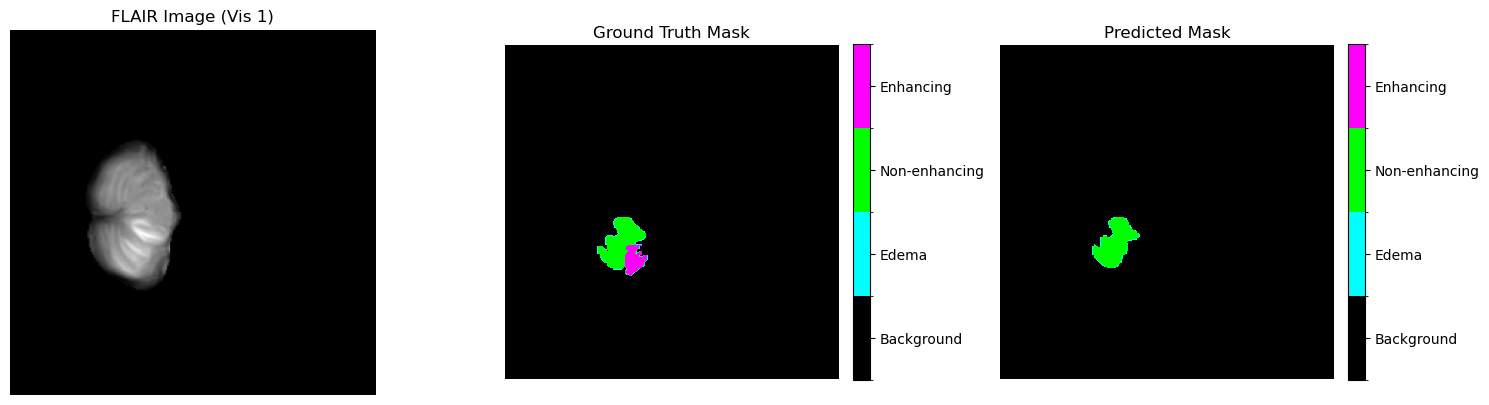

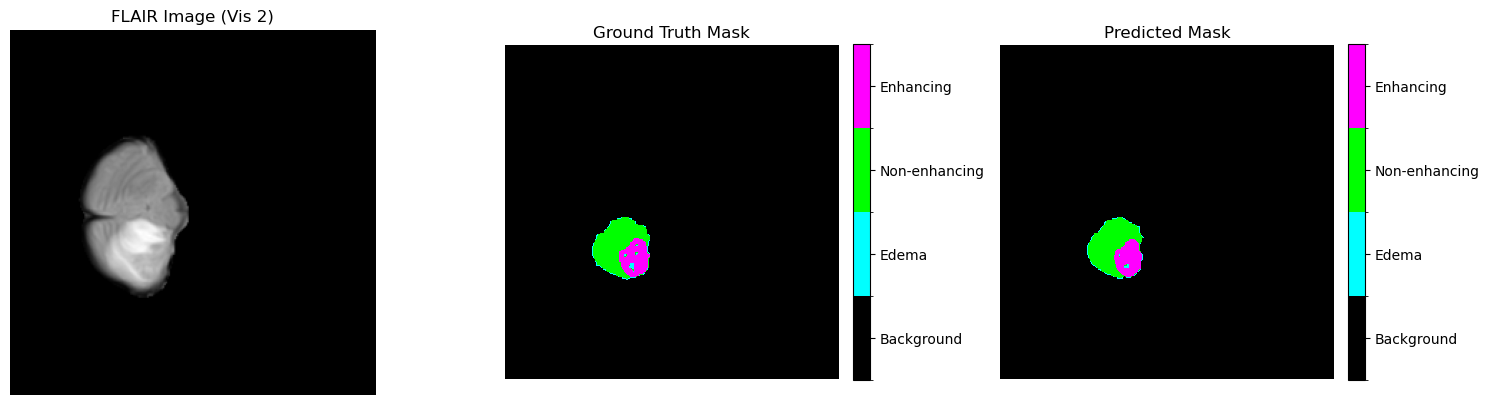

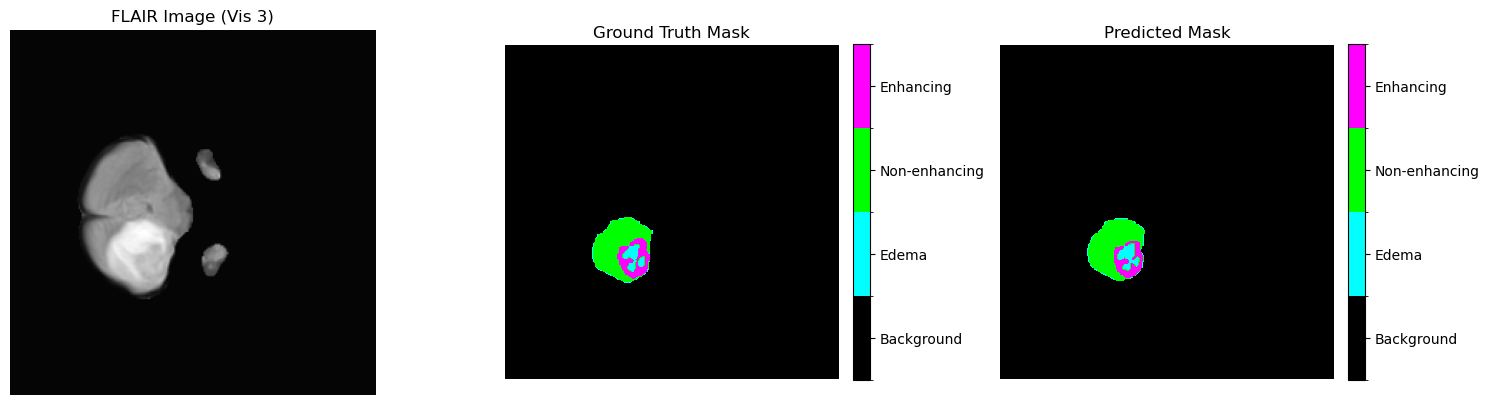

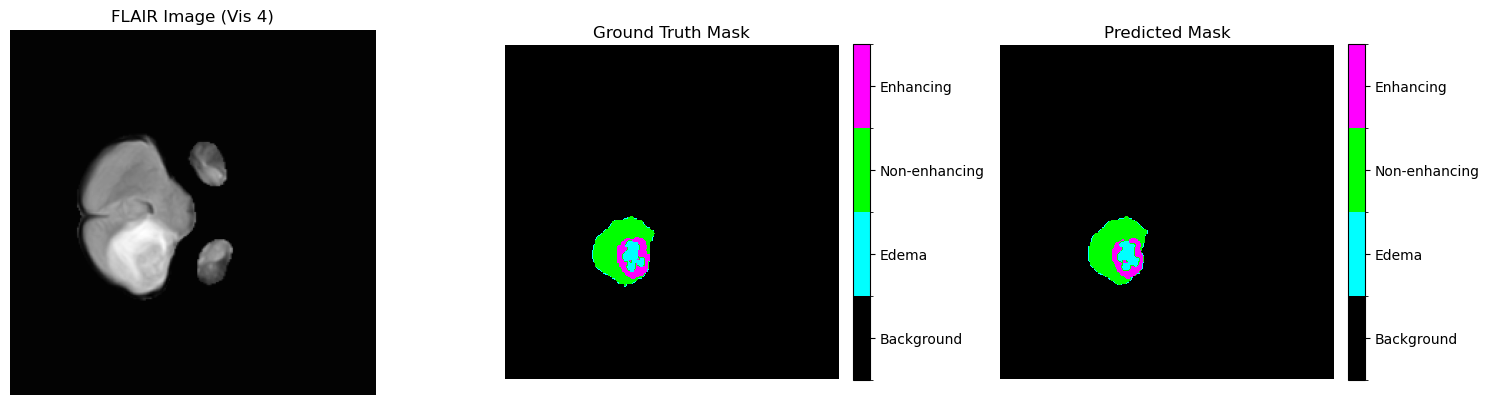

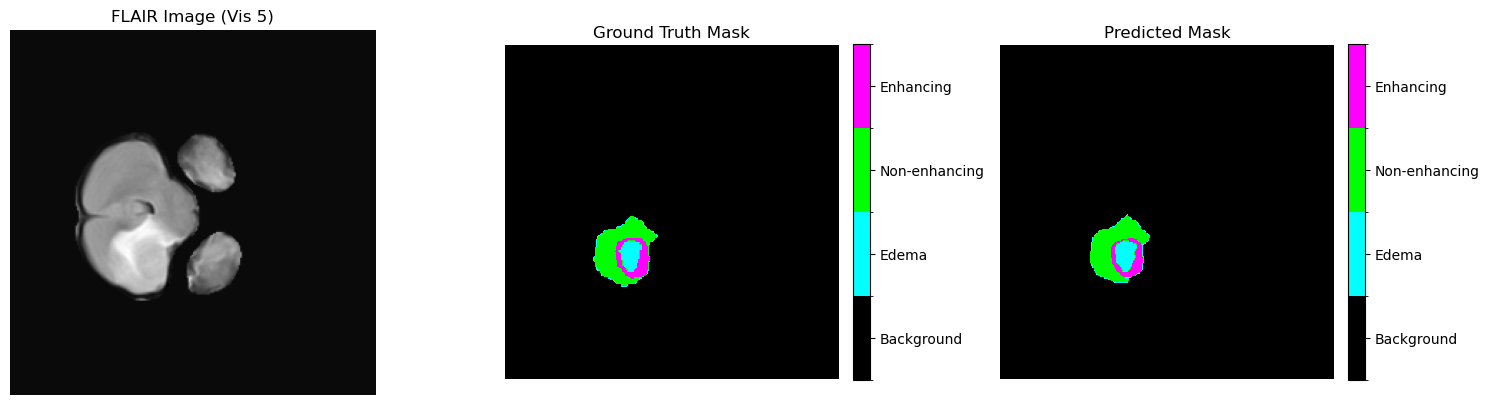

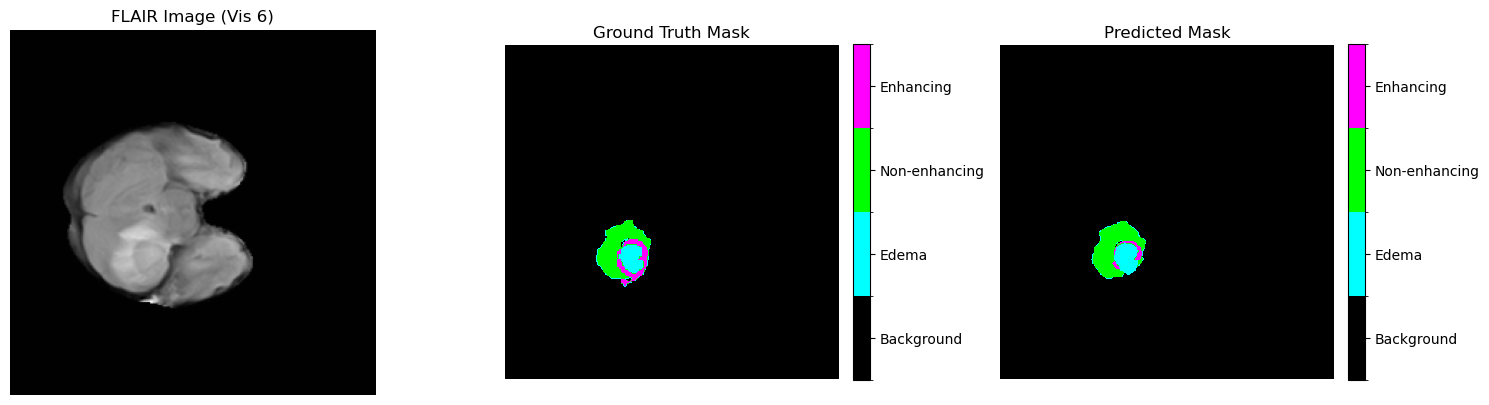

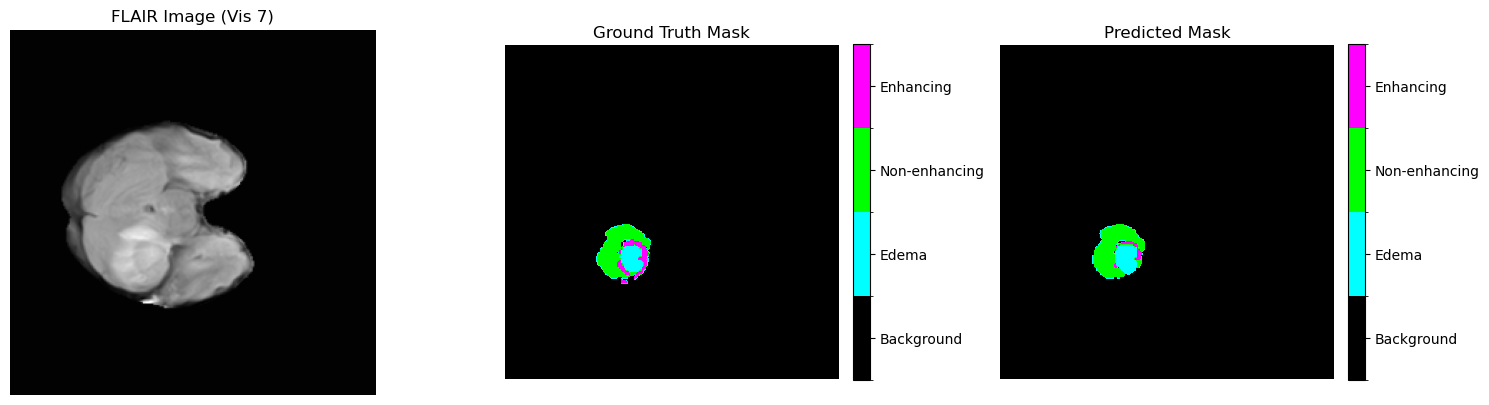

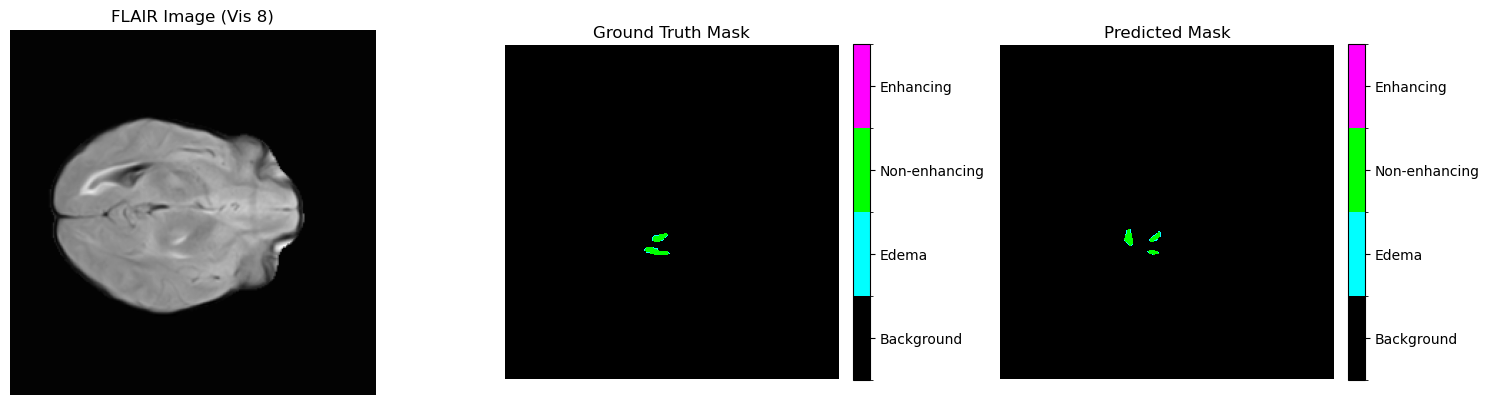

Visualizing samples:   1%|          | 1/112 [00:01<03:35,  1.94s/it]

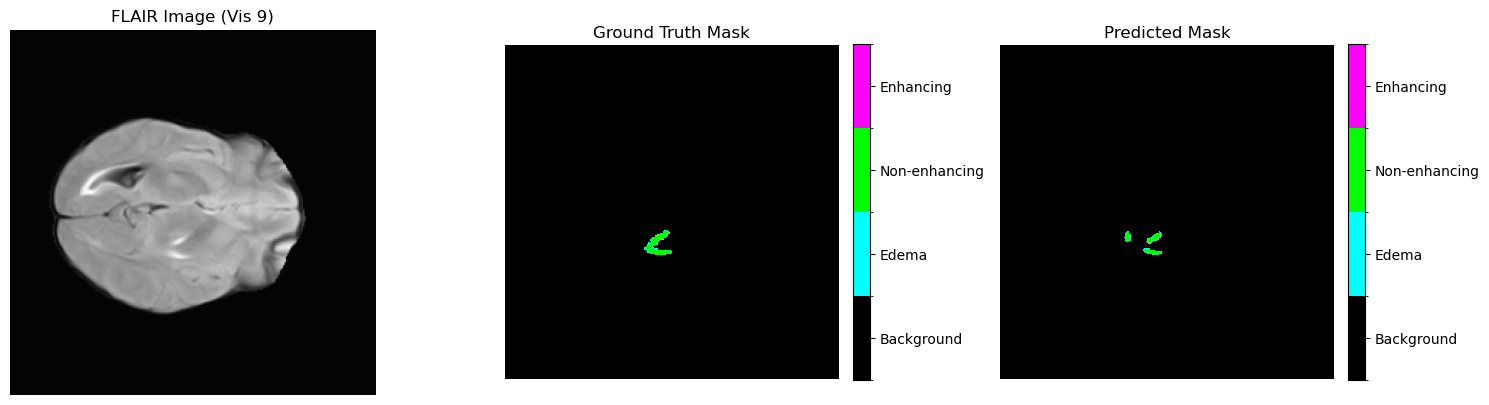

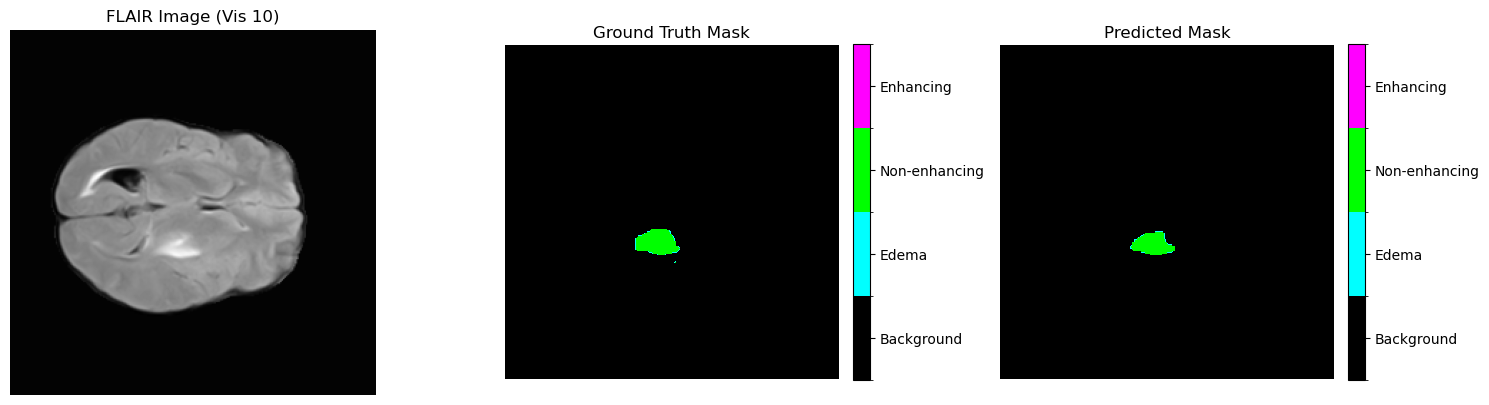

Visualizing samples:   1%|          | 1/112 [00:02<04:21,  2.36s/it]

Visualization of 10 sample predictions completed.


In [17]:
# --- Define a custom colormap here ---
# Mapping example:
# 0: black (background)
# 1: cyan (e.g., Edema)
# 2: lime (e.g., Non-enhancing tumor core)
# 3: magenta (e.g., Enhancing tumor)
colors = [
    [0.0, 0.0, 0.0, 1.0],      # Black for class 0 (background)
    [0.0, 1.0, 1.0, 1.0],      # Cyan for class 1 (Edema - approximated from image)
    [0.0, 1.0, 0.0, 1.0],      # Lime for class 2 (Non-enhancing - approximated from image)
    [1.0, 0.0, 1.0, 1.0]       # Magenta for class 3 (Enhancing - approximated from image)
]
cmap_custom = ListedColormap(colors)

# Define boundaries for the colormap to ensure discrete coloring
# For N classes, need N+1 boundaries. Example: for 0,1,2,3, boundaries are -0.5, 0.5, 1.5, 2.5, 3.5
bounds = [-0.5 + i for i in range(NUM_CLASSES + 1)]
norm = BoundaryNorm(bounds, cmap_custom.N)

# --- 1. Load the trained model ---
VISUALIZE_FOLD_NUM = 1 # Choose the fold want to visualize from (e.g., 1 to 5)
model_path = os.path.join("./brats_kfold_runs", f"fold{VISUALIZE_FOLD_NUM}", "best_model.pth")
# Or to load the SWA model:
# model_path = os.path.join("./brats_kfold_runs", f"fold{VISUALIZE_FOLD_NUM}", "swa_model.pth")


if not os.path.exists(model_path):
    print(f"Error: Model not found at {model_path}. Please ensure it exists.")
else:
    print(f"Loading model from {model_path}...")
    model = AttentionUNet(IMG_CHANNELS, NUM_CLASSES).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval() # Set the model to evaluation mode
    print("Model loaded successfully.")

    # --- 2. Create the val_loader (validation DataLoader) ---
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    val_subset_indices = None
    all_indices = list(range(len(full_dataset))) 
    
    for i, (train_idx, val_idx) in enumerate(kfold.split(full_dataset)):
        if i + 1 == VISUALIZE_FOLD_NUM:
            val_subset_indices = val_idx
            break

    if val_subset_indices is not None:
        val_subset = Subset(full_dataset, val_subset_indices)
        val_dataset_transformed = TransformedDataset(val_subset, get_val_transforms())
        val_loader = DataLoader(val_dataset_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, persistent_workers=True)
        print("Validation DataLoader created.")

        # --- MODIFIED VISUALIZATION CODE STARTS HERE (to show multiple slices) ---
        max_visualizations = 10 # <--- SET THIS TO THE NUMBER OF SLICES WANT TO SEE
        current_visualizations = 0 # Counter for displayed slices

        print(f"\nStarting visualization of up to {max_visualizations} valid predictions...")
        with torch.no_grad():
            # Iterate through the validation loader
            for images, masks in tqdm(val_loader, desc="Visualizing samples"):
                images, masks = images.to(DEVICE), masks.to(DEVICE).long()

                outputs = model(images)
                preds_soft = F.softmax(outputs, dim=1)
                pred_labels = torch.argmax(preds_soft, dim=1)

                for i in range(images.size(0)):
                    # Only show slices with tumor based on ground truth
                    if (masks[i] > 0).sum() > 0: # Check if any non-background class is present
                        flair = images[i, 3].cpu().numpy()
                        gt = masks[i].cpu().numpy()
                        pred_display = pred_labels[i].cpu().numpy()

                        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

                        axs[0].imshow(flair, cmap='gray')
                        axs[0].set_title(f"FLAIR Image (Vis {current_visualizations + 1})") # Added slice number
                        axs[0].axis('off')

                        im1 = axs[1].imshow(gt, cmap=cmap_custom, norm=norm)
                        axs[1].set_title("Ground Truth Mask")
                        axs[1].axis('off')
                        cbar = fig.colorbar(im1, ax=axs[1], ticks=np.arange(NUM_CLASSES), fraction=0.046, pad=0.04)
                        cbar.ax.set_yticklabels(['Background', 'Edema', 'Non-enhancing', 'Enhancing']) # Customize labels

                        im2 = axs[2].imshow(pred_display, cmap=cmap_custom, norm=norm)
                        axs[2].set_title("Predicted Mask")
                        axs[2].axis('off')
                        cbar_pred = fig.colorbar(im2, ax=axs[2], ticks=np.arange(NUM_CLASSES), fraction=0.046, pad=0.04)
                        cbar_pred.ax.set_yticklabels(['Background', 'Edema', 'Non-enhancing', 'Enhancing'])
                        
                        plt.tight_layout()
                        plt.show()

                        current_visualizations += 1 # Increment counter
                        
                        if current_visualizations >= max_visualizations:
                            break # Exit inner loop if max_visualizations reached
                
                if current_visualizations >= max_visualizations:
                    break # Exit outer loop if max_visualizations reached

        print(f"Visualization of {current_visualizations} sample predictions completed.")
    else:
        print(f"Could not prepare val_loader for Fold {VISUALIZE_FOLD_NUM}.")

/tmp/ipykernel_2627158/4292309312.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))


Custom colormap created.
Loading model from ./brats_kfold_runs/fold1/best_model.pth...
Model loaded successfully.
Validation DataLoader created.
images.shape: torch.Size([8, 4, 256, 256])
outputs.shape: torch.Size([8, 4, 256, 256])
outputs stats: min = -12.384604454040527 max = 11.955541610717773 mean = -2.812357187271118
Any NaNs in output: False
Unique predicted classes: tensor([0, 1, 2, 3], device='cuda:0')


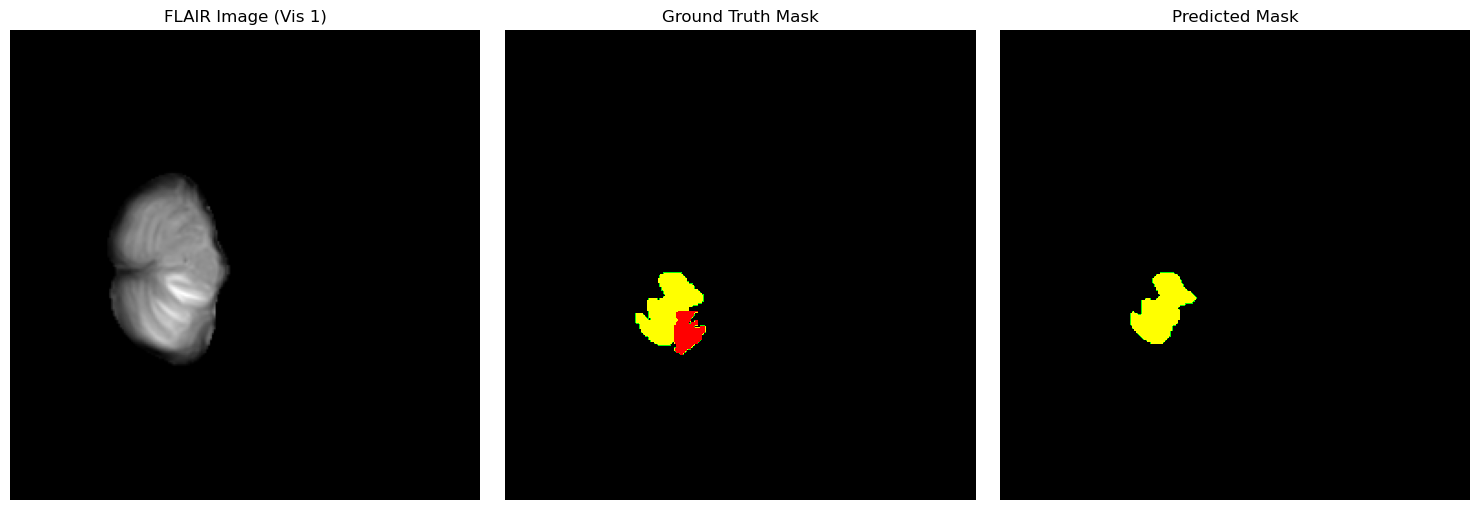

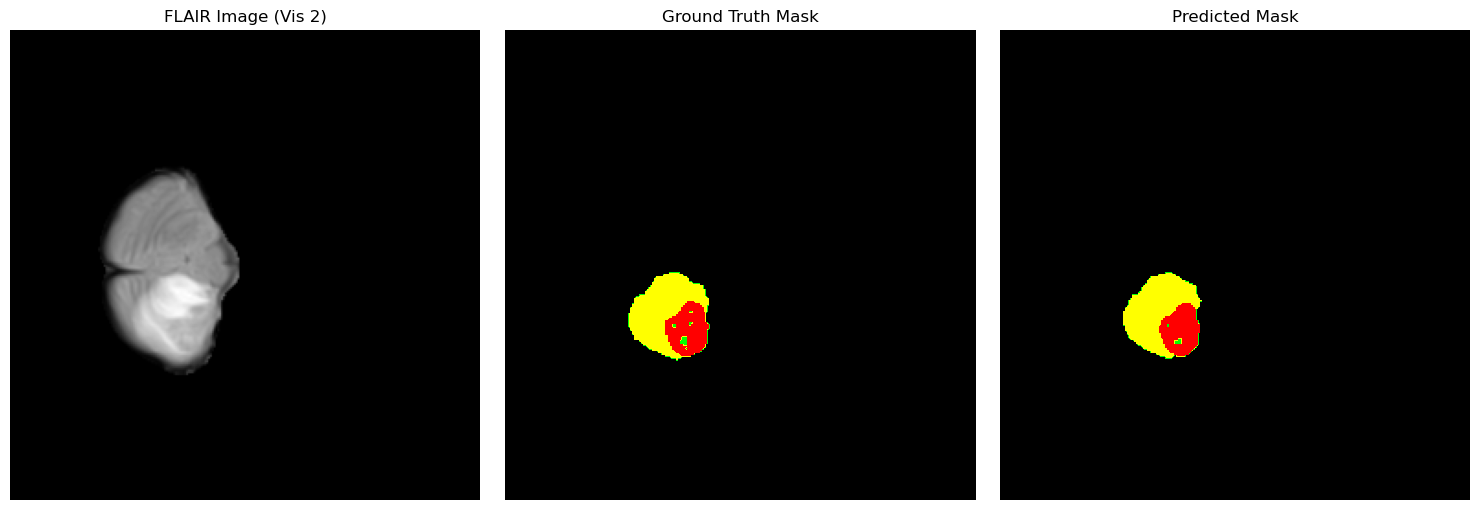

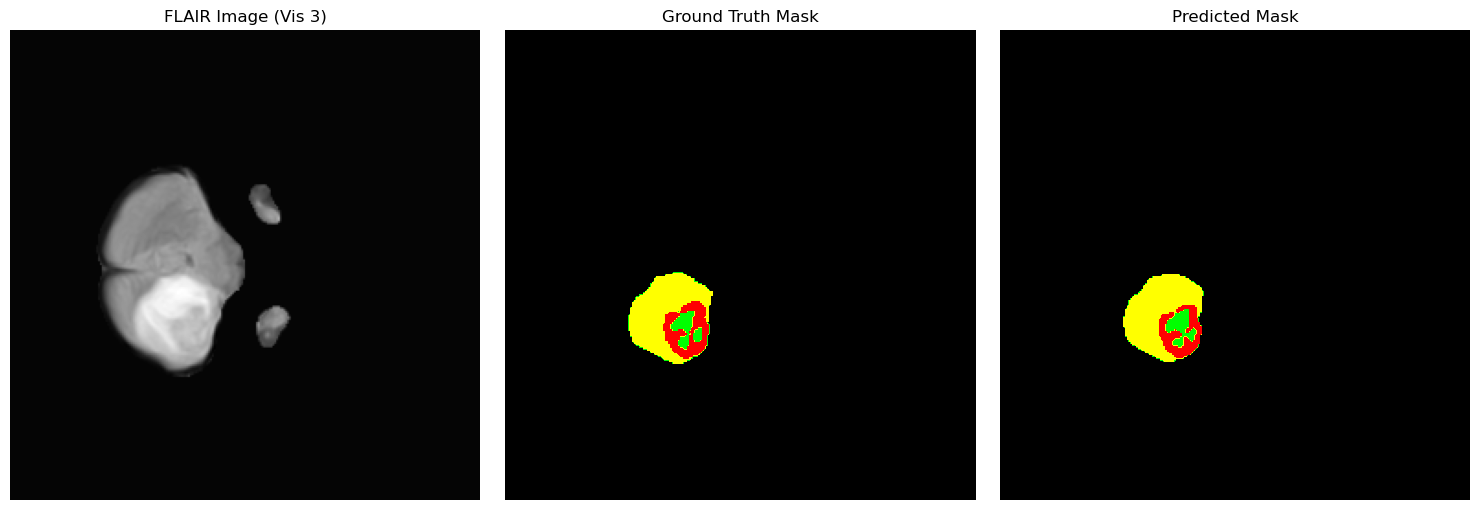

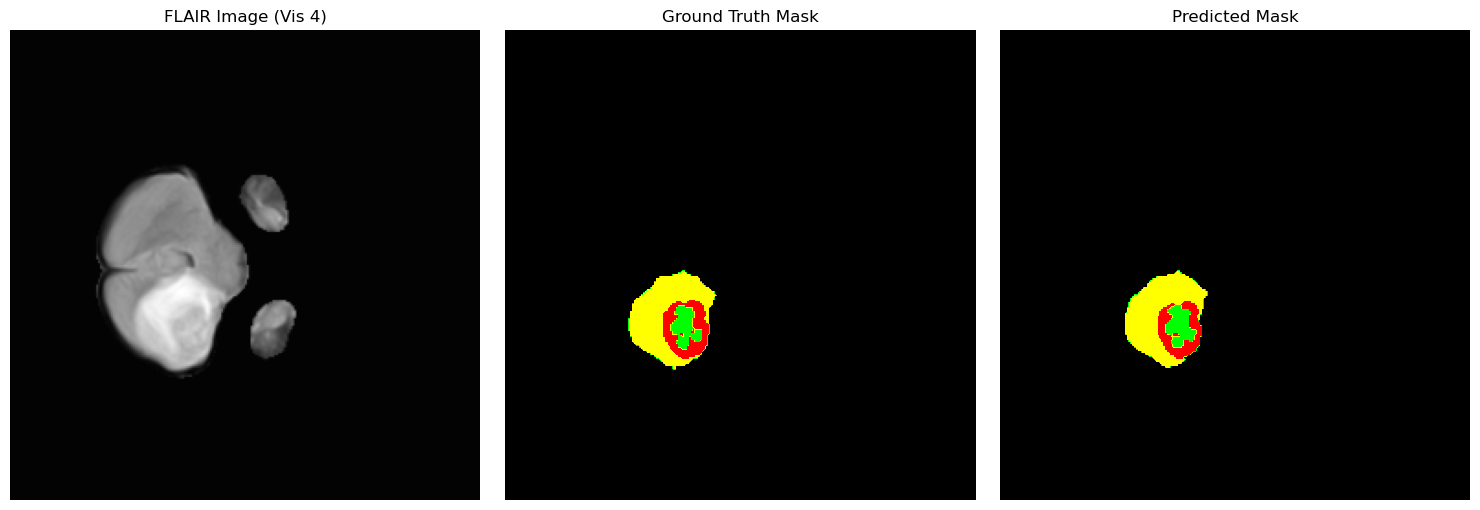

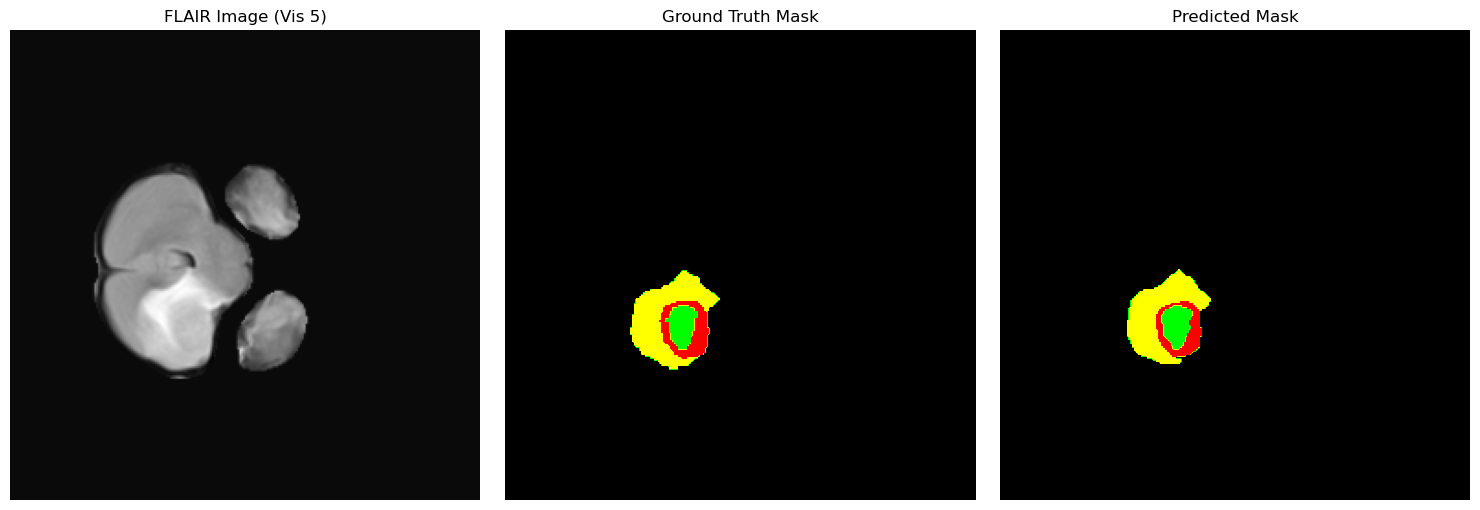

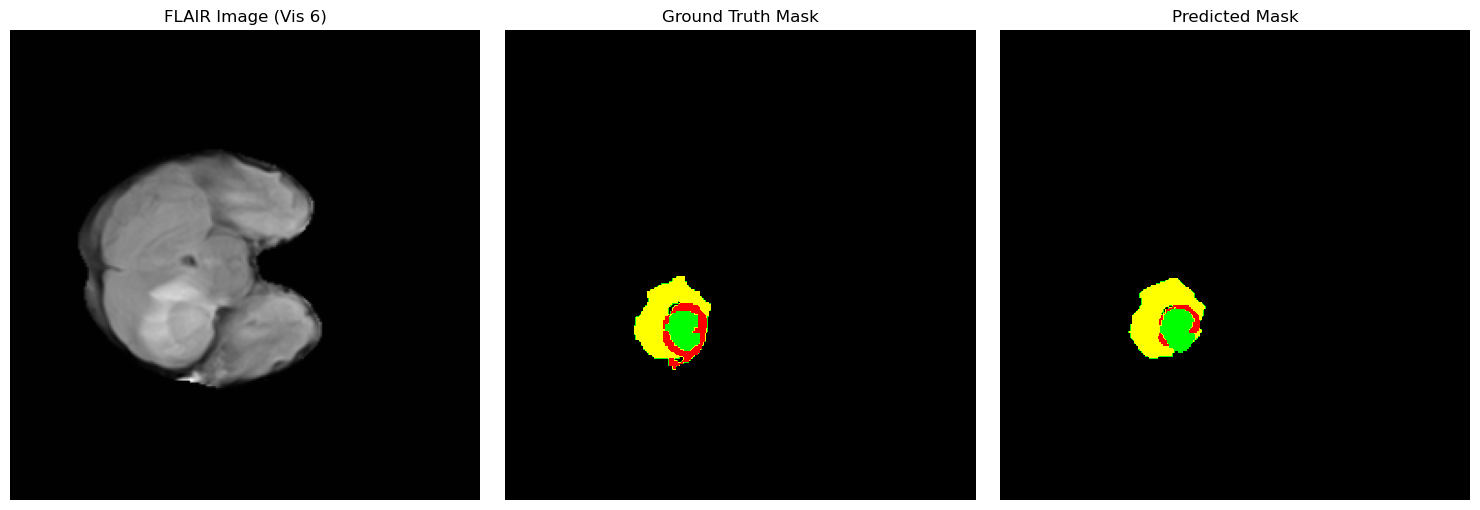

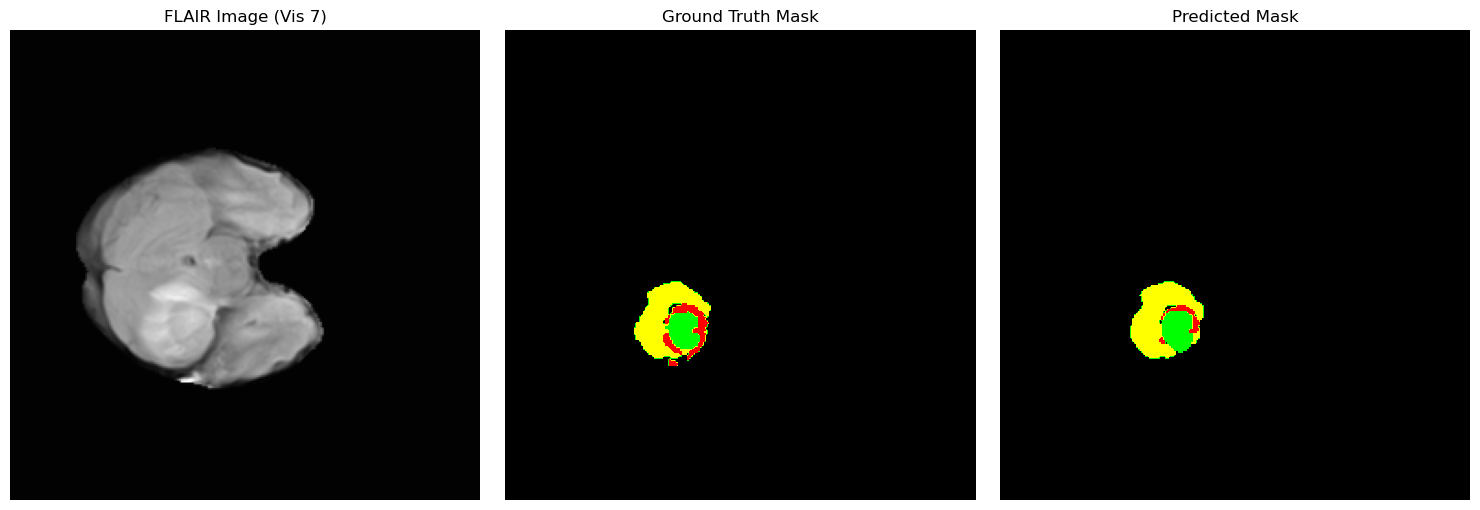

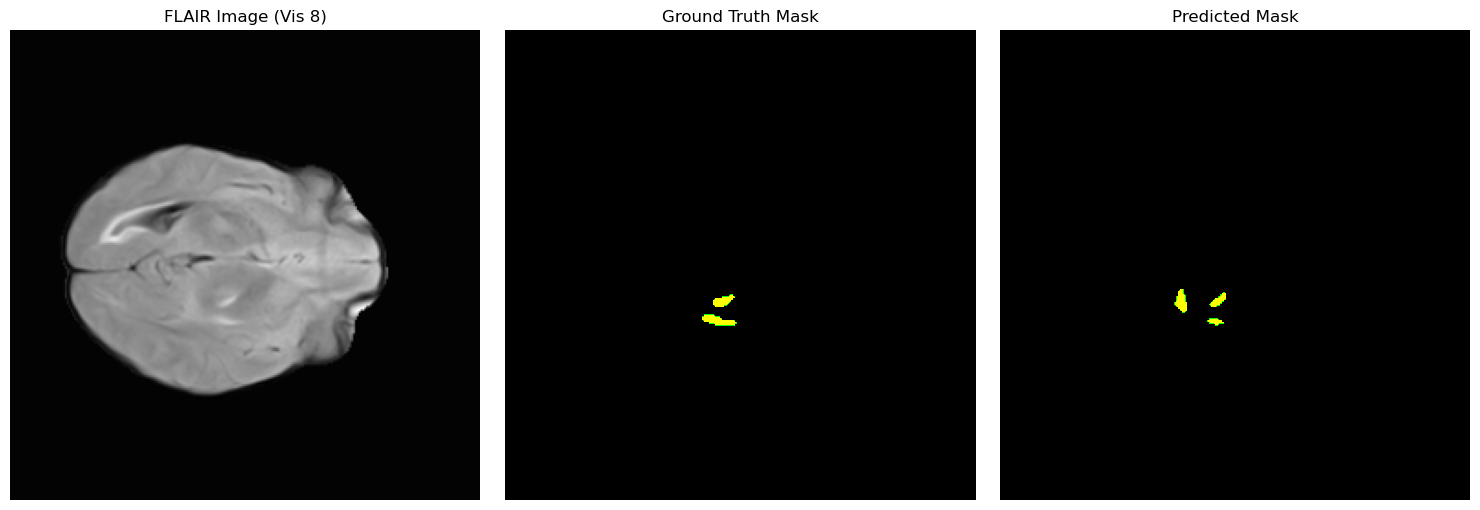

images.shape: torch.Size([8, 4, 256, 256])
outputs.shape: torch.Size([8, 4, 256, 256])
outputs stats: min = -13.751258850097656 max = 12.165781021118164 mean = -2.738980531692505
Any NaNs in output: False
Unique predicted classes: tensor([0, 1, 2, 3], device='cuda:0')


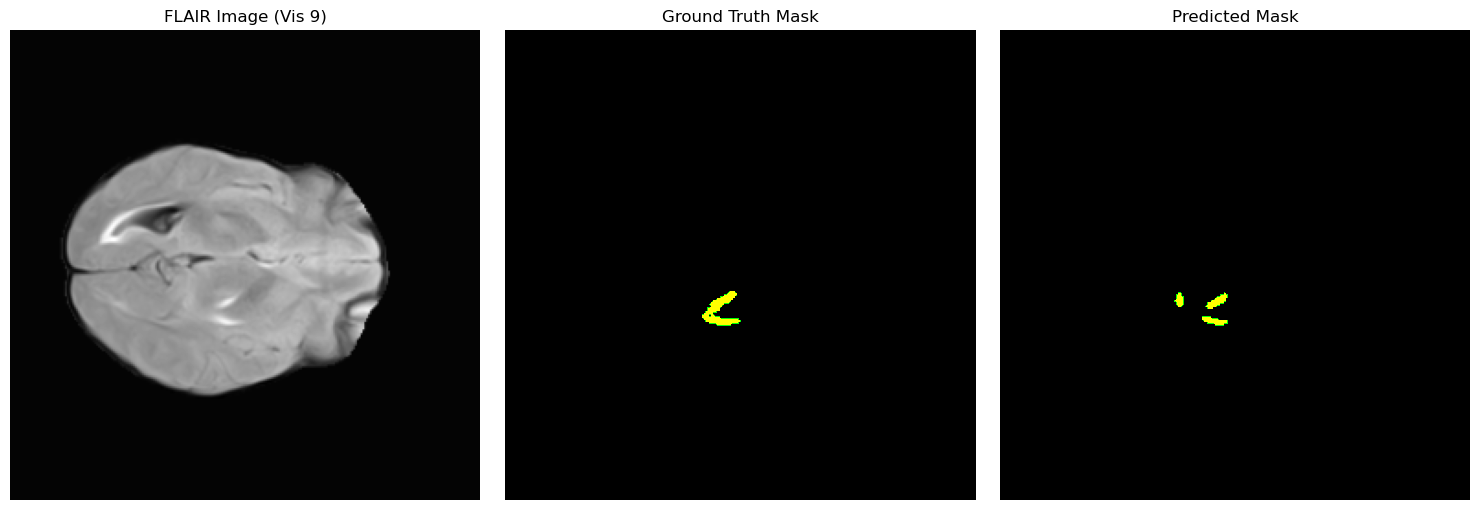

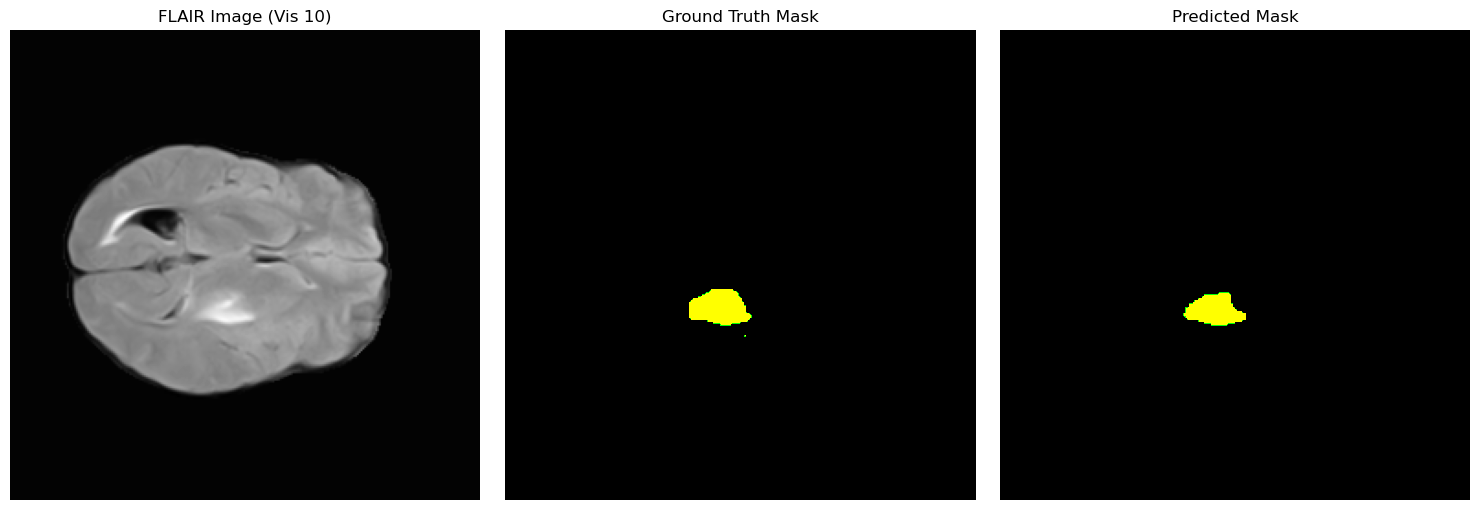

Visualization of 10 sample predictions completed.


In [18]:
# --- Define your custom colormap here ---
custom_colors = [
    [0.0, 0.0, 0.0],  # Black for Class 0 (Background)
    [0.0, 1.0, 0.0],  # Green for Class 1
    [1.0, 1.0, 0.0],  # Yellow for Class 2
    [1.0, 0.0, 0.0]   # Red for Class 3
]
custom_cmap = ListedColormap(custom_colors)
print("Custom colormap created.")

# --- 1. Load the trained model ---
VISUALIZE_FOLD_NUM = 1 # You can change this to 2, 3, 4, or 5
model_path = os.path.join("./brats_kfold_runs", f"fold{VISUALIZE_FOLD_NUM}", "best_model.pth")
# Or to load the SWA model:
# model_path = os.path.join("./brats_kfold_runs", f"fold{VISUALIZE_FOLD_NUM}", "swa_model.pth")


if not os.path.exists(model_path):
    print(f"Error: Model not found at {model_path}. Please ensure it exists.")
else:
    print(f"Loading model from {model_path}...")
    model = AttentionUNet(IMG_CHANNELS, NUM_CLASSES).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval() # Set the model to evaluation mode
    print("Model loaded successfully.")

    # --- 2. Create the val_loader (validation DataLoader) ---
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    val_subset_indices = None
    all_indices = list(range(len(full_dataset))) 
    
    for i, (train_idx, val_idx) in enumerate(kfold.split(full_dataset)):
        if i + 1 == VISUALIZE_FOLD_NUM:
            val_subset_indices = val_idx
            break

    if val_subset_indices is not None:
        val_subset = Subset(full_dataset, val_subset_indices)
        val_dataset_transformed = TransformedDataset(val_subset, get_val_transforms())
        val_loader = DataLoader(val_dataset_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, persistent_workers=True)
        print("Validation DataLoader created.")

        # --- Your visualization code starts here (modified for 10 slices) ---
        max_visualizations = 10 # Set the number of samples you want to visualize
        current_visualizations = 0 # Counter for how many we've visualized

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)

                # --- Diagnostics (optional, can comment these out if they clutter output) ---
                print("images.shape:", images.shape)
                print("outputs.shape:", outputs.shape)
                print("outputs stats: min =", outputs.min().item(),
                            "max =", outputs.max().item(),
                            "mean =", outputs.mean().item())
                print("Any NaNs in output:", torch.isnan(outputs).any().item())
                print("Unique predicted classes:", torch.unique(preds))
                
                # Iterate through the batch to visualize individual samples
                for i in range(images.size(0)):
                    if masks[i].sum() > 0: # Only show slices with non-empty ground truth mask
                        flair = images[i, 3].cpu().numpy()
                        gt = masks[i].cpu().numpy()
                        pred = preds[i].cpu().numpy()

                        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                        
                        axs[0].imshow(flair, cmap='gray')
                        axs[0].set_title(f"FLAIR Image (Vis {current_visualizations + 1})") # Added count to title
                        axs[0].axis('off')

                        axs[1].imshow(gt, cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES - 1)
                        axs[1].set_title("Ground Truth Mask")
                        axs[1].axis('off')

                        axs[2].imshow(pred, cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES - 1)
                        axs[2].set_title("Predicted Mask")
                        axs[2].axis('off')

                        plt.tight_layout()
                        plt.show() # Display the plot

                        current_visualizations += 1 # Increment counter
                        
                        if current_visualizations >= max_visualizations:
                            break # Exit inner loop if we've reached the limit
                
                if current_visualizations >= max_visualizations:
                    break # Exit outer loop (dataloader iteration) if limit reached

        print(f"Visualization of {current_visualizations} sample predictions completed.")
    else:
        print(f"Could not prepare val_loader for Fold {VISUALIZE_FOLD_NUM}.")

In [19]:
#addition for prediction starts here from MY